In [2]:
#Imports

import numpy as np
import os
import shutil
import openpyxl as oxl
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from copy import deepcopy

from datetime import datetime

from collections import deque

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from PIL import Image
import cv2

import json
import xml.etree.ElementTree as ET
#this is to automatically parse xml into dict
import xmltodict

import collections

import math

#for finding the shortest distance btw curve and point
from scipy.optimize import fmin_cobyla

# This is needed if the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

#imports from object-detection module
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

## Preparing WM logs using keyPoint detection and YOLO LSTM

### Method Definitions

In [3]:
def draw_patch_keypoints(image, patch_keypoints, validKeypoints = []):
    colors = [[255, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0], [153, 255, 255]]
    circle_radius=5

    for i, joint_keypoint in enumerate(patch_keypoints):
        x, y = joint_keypoint
        
        if x == 0 or y == 0:
            continue
            
        if len(validKeypoints) > 1 and joint_keypoint not in validKeypoints:
            continue

        cv2.circle(image, (x, y), circle_radius, colors[i], -1)

    return image

In [4]:
def draw_fittedCurves_for1setOfKeypoints(image, setof_keypoints, esimatorFunction, colorNb=0):
    #colors = [[204, 0, 204], [255, 255, 51], [255, 51, 255], [153, 51, 255], [255, 102, 255], [178, 102, 255]]
    colors = [[255, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0], [153, 255, 255]]
    
    #pts = [[p[0], int(esimatorFunction(p[0]))] for p in setof_keypoints if(p[0] > 0 and p[1]>0)]
    pts = [[indx, int(esimatorFunction(indx))] for indx in range(10, 600, 50)]
    pts_np = np.array(pts, np.int32)
    pts_np = pts_np.reshape((-1,1,2))
    cv2.polylines(image,[pts_np],False,colors[colorNb])

    return image

In [5]:
def draw_box(image, box):
    colors = [(0, 255, 0), (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),(0, 255, 255)]
    labels=["Tooth", "Toothline", "BucketBB", "MatInside", "WearArea"]
    image_h, image_w, _ = image.shape
    
    if len(box) > 3:
        xmin = int(box[0] * image_w)
        xmax = int(box[1] * image_w)
        ymin = int(box[2] * image_h)
        ymax = int(box[3] * image_h)
        label, score = box[4:6]
        #print(str(xmin) + '  ' + str(xmax) + '  '  + str(ymin) + '  ' + str(ymax) + '  ' + label)
        
        #add tooth length (from box) as a field
        box.append(ymax-ymin)

        if xmin < 0: xmin = 0
        if ymin < 0: ymin = 0

        color = colors[labels.index(label)]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        font_increase = 1.
        cv2.putText(
            image,
            str(score),
            (xmin, ymin - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            8e-4 * image_h * font_increase,
            color, 2)

    return image

In [6]:
def draw_all_boxes(image, boxesDict):
    for key in boxesDict.keys():
        if 'keypoints' not in key and key not in ['nbOfDetectedTeeth','fileName', 'fittedCurves', '2ndDerivFittedCurves']:
            image = draw_box(image, boxesDict[key])
            
    return image

In [7]:
def draw_all_keypoints_boxes_andCurves(inImage, resultsDict, numberOfTeeth, refKey='', regTypeKeyword='', drawOnlyValidated=False, doNotDrawBoxes=True, numberOflandmarksIncludingToothTip = 5):

    image = inImage.copy()
    
    if regTypeKeyword == '':
        esimatorFunctions = resultsDict['fittedCurves']
        
        for toothNb in range(numberOfTeeth):
            toothKeyPointKey = regTypeKeyword + 'keypointsForTooth_' + str(toothNb + 1)

            if toothKeyPointKey in resultsDict:

                if drawOnlyValidated:
                    image = draw_patch_keypoints(image, resultsDict[toothKeyPointKey], resultsDict[regTypeKeyword +'validatedKeypoints'])
                else:
                    image = draw_patch_keypoints(image, resultsDict[toothKeyPointKey], [])


        for keypointNb in range(numberOflandmarksIncludingToothTip):
            toothKeyPointKey = 'keypoints_' + str(keypointNb + 1)

            if toothKeyPointKey in esimatorFunctions:
                image = draw_fittedCurves_for1setOfKeypoints(image, resultsDict[toothKeyPointKey], esimatorFunctions[toothKeyPointKey], colorNb=keypointNb)


        if not doNotDrawBoxes:
            draw_all_boxes(image, resultsDict)

        return image


    else:
        esimatorFunctions = resultsDict['registrations'][refKey][regTypeKeyword + 'fittedCurves']
    
        for toothNb in range(numberOfTeeth):
            toothKeyPointKey = regTypeKeyword + 'keypointsForTooth_' + str(toothNb + 1)

            if toothKeyPointKey in resultsDict['registrations'][refKey]:

                if drawOnlyValidated:
                    image = draw_patch_keypoints(image, resultsDict['registrations'][refKey][toothKeyPointKey], resultsDict['validatedKeypoints'])
                else:
                    image = draw_patch_keypoints(image, resultsDict['registrations'][refKey][toothKeyPointKey], [])


        for keypointNb in range(numberOflandmarksIncludingToothTip):
            toothKeyPointKey = 'keypoints_' + str(keypointNb + 1)

            if toothKeyPointKey in esimatorFunctions:
                image = draw_fittedCurves_for1setOfKeypoints(image, resultsDict[toothKeyPointKey], esimatorFunctions[toothKeyPointKey], colorNb=keypointNb)


        if not doNotDrawBoxes:
            draw_all_boxes(image, resultsDict)

        return image

In [8]:
def dimg(framesDir, fileName, teethBoxes, keypoints):
    inImage = cv2.imread(framesDir + fileName.replace('.json','.png'))
    outImage = draw_all_keypoints(inImage, data[0], circle_radius=3)
    outImage = draw_boxes(outImage, data[1]) 
    plt.imshow(outImage)
    plt.show()

In [9]:
def getFrameTime(resultsDict, resultsKey, fileName):
    for timeKey in resultsDict[resultsKey].keys():
        if fileName in resultsDict[resultsKey][timeKey]['fileName']:
            print(timeKey)
            print(resultsDict[resultsKey][timeKey]['fileName'])
            print('\n')
            return timeKey
    
    print('could not find the requested file')
    return None

In [10]:
def loadResults(resultsDir, rawFramesDir=None):
    #Load JSON prediciton results from disc into dict
    resultsDirectories = []


    
    #for resultsDir in resultsDirectories:
    resultsDir = wmsDir
    resultKey = resultsDir.split('/')[-3]

    
    


    resultsDic = {}

    datetimemask = "%Y.%m.%d %H.%M.%S"
    
    resultsDic[resultKey] = {}

    zeroTimeRef = None

    for fileName in sorted(os.listdir(resultsDir)):
        if fileName and '.json' in fileName:

            fileNameAr = fileName[:len(fileName)-5].split('_')
            time = fileNameAr[1] + ' ' + fileNameAr[2]
            dateTime = datetime.strptime(time, datetimemask)

            curHourSince = 0

            if zeroTimeRef == None:
                zeroTimeRef = dateTime
            else:
                timeDif = dateTime - zeroTimeRef
                totalSeconds = timeDif.seconds
                totalDays = timeDif.days
                curHourSince = totalSeconds/3600 + totalDays*24



            with open(resultsDir + fileName, 'r') as fjson:
                data = tuple(json.load(fjson))
                #print(fileName)

                resultsDic[resultKey][curHourSince] = {}      
                resultsDic[resultKey][curHourSince]['time'] = time
                resultsDic[resultKey][curHourSince]['keypoints'] = data[0]
                resultsDic[resultKey][curHourSince]['teeth'] = data[1]
                resultsDic[resultKey][curHourSince]['buckets'] = data[2]
                resultsDic[resultKey][curHourSince]['nbOfDetectedTeeth'] = len(data[1])
                resultsDic[resultKey][curHourSince]['fileName'] = resultsDir + fileName.replace('.json', '.png')
                tempImage = cv2.imread(resultsDic[resultKey][curHourSince]['fileName'])
                image_h, image_w, _ = tempImage.shape
                resultsDic[resultKey][curHourSince]['image_h'] = image_h
                resultsDic[resultKey][curHourSince]['image_w'] = image_w
                


            #print(resultsDic)
            #dimg(rawFramesDir, fileName, data)
            #break



    print("loaded the results for  " + str(len(resultsDic[resultKey])) + "   frames. For key: " + resultKey)
    return resultsDic

In [11]:
def parseResults(resultsDic, numberOfTeeth):
    numberOflandmarksIncludingToothTip = 5
    paresedResultsDict = {}
    
    for resKey in resultsDic.keys():
        paresedResultsDict[resKey] = {}
        
        for time in resultsDic[resKey].keys():
            paresedResultsDict[resKey][time] = {}
            
            paresedResultsDict[resKey][time]['nbOfDetectedTeeth'] = resultsDic[resKey][time]['nbOfDetectedTeeth'] 
            paresedResultsDict[resKey][time]['fileName'] = resultsDic[resKey][time]['fileName']
            paresedResultsDict[resKey][time]['image_h'] = resultsDic[resKey][time]['image_h']
            paresedResultsDict[resKey][time]['image_w'] = resultsDic[resKey][time]['image_w']
            
            #parse the bucket objects
            for obj in resultsDic[resKey][time]['buckets']:
                paresedResultsDict[resKey][time][obj[4]] = obj
                
            #parse the teeth 
            toothNb = 1
            for obj in sorted(resultsDic[resKey][time]['teeth'], key=lambda rv: rv[0]):
                paresedResultsDict[resKey][time]['Tooth_' + str(toothNb)] = obj
                toothNb += 1
                
            toothNb = 1
            for keypointsSet in sorted(resultsDic[resKey][time]['keypoints'], key=lambda kv: kv[0]):           
                paresedResultsDict[resKey][time]['keypointsForTooth_' + str(toothNb)] = keypointsSet
                toothNb += 1
                
                
            for keypointsNb in range(numberOflandmarksIncludingToothTip):       
                paresedResultsDict[resKey][time]['keypoints_' + str(keypointsNb + 1)] = [keypointsSet[keypointsNb] for keypointsSet in sorted(resultsDic[resKey][time]['keypoints'], key=lambda kv: kv[0])]
            
                
    return paresedResultsDict

In [12]:
def getMinDistanceBtwPointAndToothBox(toothBox, landmarkPointsList, image_h):
    outDist = 10000
    
    yminBox = int(toothBox[2] * image_h)
    ymaxBox = int(toothBox[3] * image_h)
    
    x0, y0 = landmarkPointsList[0]
    _, y1 = landmarkPointsList[0]
        
    if not (x0 == 0 or y0 == 0):
        outDist = min( min( abs(yminBox - y0), abs(ymaxBox - y0) ), min( abs(yminBox - y1), abs(ymaxBox - y1) ) )

    return outDist

In [13]:
def getDistanceBtwEdges(leftBox, rightBox):
    xmaxLeft = float(leftBox[1])
    xminRight = float(rightBox[0])

    return xminRight - xmaxLeft

In [14]:
def reject1_badBoxesAndLandmarks(
    parsedResultsDic,
    rejectedResultsDir,
    numberOfTeeth,
    minToothBoxDistanceAllowed,
    numberOflandmarksIncludingToothTip,
    lanmark2farFromBox_epsilon,
    landmarks2close2eachother_epsilon,
    verbose=False):

    filteredResults = deepcopy(parsedResultsDic)
    
    
    for resKey in parsedResultsDic.keys():
        deletedCount = 0
        deletedDuplicateKeypointCount = 0
        
        for time in parsedResultsDic[resKey].keys():
            filePath = paresedResultsDict[resKey][time]['fileName']
            fileName = filePath.split('/')[-1]
            
            
            #***********************************************************************************************#
            #reject1 get rid of adjacent tooth boxes that are too close to eachother
            for toothNb in range(numberOfTeeth - 1):
                toothKeyLeft = 'Tooth_' + str(toothNb + 1)
                toothKeyRight = 'Tooth_' + str(toothNb + 2)
                
                if toothKeyLeft in parsedResultsDic[resKey][time] and toothKeyRight in parsedResultsDic[resKey][time]:
                    distanceBtwAdjTeeth = getDistanceBtwEdges(
                        parsedResultsDic[resKey][time][toothKeyLeft],
                        parsedResultsDic[resKey][time][toothKeyRight]
                    )

                    if distanceBtwAdjTeeth <= minToothBoxDistanceAllowed:
                        del filteredResults[resKey][time]['Tooth_' + str(toothNb + 2)]
                        paresedResultsDict[resKey][time]['nbOfDetectedTeeth'] = 0 #this garantees reject
                        filteredResults[resKey][time]['nbOfDetectedTeeth'] = 0 #this garantees reject
                        
                        if verbose:
                            print('\nrejected:\n' + str(filePath) + '\nbecause adjacent teeth were too close.')
            #***********************************************************************************************#
                        
            
            #***********************************************************************************************#
            #reject2  get rid of toothtips and lipshrouds that are not inside their tooth box
            for toothNb in range(numberOfTeeth - 1):
                toothKey = 'Tooth_' + str(toothNb + 1)  
                keypointKey = 'keypointsForTooth_' + str(toothNb + 1)
                
                if toothKey in filteredResults[resKey][time]:
                    miDis = getMinDistanceBtwPointAndToothBox(
                        filteredResults[resKey][time][toothKey],
                        filteredResults[resKey][time][keypointKey],
                        filteredResults[resKey][time]['image_h'])

                    if( miDis > lanmark2farFromBox_epsilon ):
                        filteredResults[resKey][time][keypointKey][0] = [0, 0]
                        filteredResults[resKey][time][keypointKey][1] = [0, 0]
                        filteredResults[resKey][time]['keypoints_' + str(1)][toothNb] = [0, 0]
                        filteredResults[resKey][time]['keypoints_' + str(2)][toothNb] = [0, 0]
                        paresedResultsDict[resKey][time]['nbOfDetectedTeeth'] = 0 #this garantees reject
                        filteredResults[resKey][time]['nbOfDetectedTeeth'] = 0 #this garantees reject
                        if verbose:
                            print('\nrejected:\n' + str(filePath) + '\nbecause landmarks were too far from box.')
            #***********************************************************************************************#
                    
                            

            #Not a reject yet get rid of landmarks with Xcords that are too close to eachother on adjacent teeth
            for lanmarkNb in range(numberOflandmarksIncludingToothTip):
                for toothNb in range(numberOfTeeth - 1):
                    if 'keypointsForTooth_' + str(toothNb+1) in filteredResults[resKey][time] and 'keypointsForTooth_' + str(toothNb+2) in filteredResults[resKey][time]:
                        
                        val2del = filteredResults[resKey][time]['keypointsForTooth_' + str(toothNb+2)][lanmarkNb]
                        
                        diff = abs(filteredResults[resKey][time]['keypointsForTooth_' + str(toothNb+1)][lanmarkNb][0] - val2del[0])

                        if diff < landmarks2close2eachother_epsilon:
                            filteredResults[resKey][time]['keypointsForTooth_' + str(toothNb+2)][lanmarkNb] = [0, 0]
                            filteredResults[resKey][time]['keypoints_' + str(lanmarkNb+1)][toothNb+1] = [0, 0]
                                                                                                               
                            deletedDuplicateKeypointCount +=1
                            
                            
                            
            
            #***********************************************************************************************#
            #reject3 not enough teeth boxes detected. (frames with missing TTips are rejected later)
            if paresedResultsDict[resKey][time]['nbOfDetectedTeeth']  < numberOfTeeth:
                shutil.copy(filePath, rejectedResultsDir)
                
                if verbose:
                    print('\nrejected:\n' + str(filePath) + '\nbecause not enough teeth were detected.')
                
                del filteredResults[resKey][time]
                deletedCount += 1
            #***********************************************************************************************#

                
            '''
            #reject4 no wearArea detected
            elif 'WearArea' not in paresedResultsDict[resKey][time].keys():
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause wearArea was not detected.')
                del filteredResults[resKey][time]
                deletedCount += 1
            '''
            
    
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' logs from the parsedResultsDic which were not copied into filteredResults. And removed ' +str(deletedDuplicateKeypointCount) + '  landmarks that had Xcords too close to each other.' )
        
        return filteredResults

In [15]:
def fitCurve2keypoints(keypoints, numberOfTeeth, keypointTypeString):
    numberOflandmarksIncludingToothTip = 5
    degreeOfPolyn = 2
    minNumberOflandmarksNeededToFitCurve = 3
    
    estimatedFunctions = {}
    
    for landmarkNb in range(numberOflandmarksIncludingToothTip):
        landmarkKey = keypointTypeString + str(landmarkNb + 1)
        key2Stor = 'keypoints_' + str(landmarkNb + 1)
        
        x = np.ndarray(shape=(1,))
        y = np.ndarray(shape=(1,))
        
        for point in keypoints[landmarkKey]:
            if(point[0] > 0 and point[1] > 0):
                x = np.vstack([x, point[0]])
                y = np.vstack([y, point[1]])
            
        x = x[1:,]
        y = y[1:,]
        x = x.reshape(-1)
        y = y.reshape(-1)
        
        if len(x) >= minNumberOflandmarksNeededToFitCurve and len(y) >= minNumberOflandmarksNeededToFitCurve:
            z = np.polyfit(x, y, degreeOfPolyn)

            estimatedFunctions[key2Stor] = np.poly1d(z)
        
    
    return estimatedFunctions

In [16]:
def get2ndDerivativeOfCurves(fittC):
    secondDervs = {}
    for key in fittC.keys():
        secondDervs[key] = fittC[key].deriv().deriv().c[0]
        
    return secondDervs

In [17]:
def getShortestDistance2Curve(testPoint, curveFunc, maxItr, verbose=False):
    
    def minimizationObjective(X):
        x,y = X
        return np.sqrt( (x - testPoint[0])**2 + (y - testPoint[1])**2 )

    def minimizationCritaria(X):
        #fmin_cobyla will make sure this is always >= 0. So I'm making sure this is > 0 only when the point is on the curve.
        x,y = X
        return abs(curveFunc(x) - y)*-1

    minDistanceSoFar = sys.maxsize
    initialGuess = testPoint
    
    for itr in range(maxItr):
        projectedPoint = fmin_cobyla(minimizationObjective, x0=initialGuess, cons=[minimizationCritaria])
        curDistance = minimizationObjective(projectedPoint)
        
        
        if verbose:
            print('itr:  ' + str(itr))
            print('minDistanceSoFar:   ' + str(minDistanceSoFar))
            print('projectedPoint is:   ' + str(projectedPoint))
            print('shortestDistance is:  ' + str(curDistance))

            x = np.linspace(-100, 1000, 100)
            plt.plot(x, curveFunc(x), 'r-', label='f(x)')
            plt.plot(testPoint[0], testPoint[1], 'bo', label='testPoint')
            plt.plot(projectedPoint[0], projectedPoint[1], 'bx', label='projectedPoint')
            plt.plot([testPoint[0], projectedPoint[0]], [testPoint[1], projectedPoint[1]], 'g-', label='shortest distance')
            plt.axis('equal')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(loc='best')
            plt.show()
        
        
        if curDistance < minDistanceSoFar:
            minDistanceSoFar = curDistance
        else:
            break
            
    projectedPointAsInt = [int(projectedPoint[0]), int(projectedPoint[1])]
    return curDistance, projectedPointAsInt

In [18]:
def reject2_soft_removeBadCurves(filteredResultsDict, path2saveCurves, rejectedPredsDir, curvDerivTreshDic, verbose=False):
    
    cleanedUpResultsDict = deepcopy(filteredResultsDict)
    
    for resKey in filteredResultsDict.keys():
        deletedKeypointsCount = 0
        totalNbOfKeyPoints = 0
        deletedCurvesCount = 0
        totalNbOfCurves = 0
        problematicFramesCount = 0
        
        for time in filteredResultsDict[resKey].keys():
            frameHadIssues = False
            fileName = filteredResultsDict[resKey][time]['fileName'].split('/')[-1]
            filePath = path2saveCurves + fileName
            
            
            for keypointsKey in curvDerivTreshDic.keys():
                totalNbOfKeyPoints += 1
                
                #***********************************************************************************************#
                #reject4 no curve calculated for this keypoint type (because there was less than 2 of them)
                if keypointsKey not in filteredResultsDict[resKey][time]['fittedCurves']:
                    del(cleanedUpResultsDict[resKey][time][keypointsKey])
                    #shutil.copy(filePath, rejectedPredsDir)
                    
                    if verbose:
                        print('\nrejected:\n' + str(filePath) + '\nbecause no curve was fitted for this keypoint type. For keypointkey: ' + keypointsKey)
                    
                    deletedKeypointsCount += 1
                    frameHadIssues = True
                #***********************************************************************************************#
                    
            
            #***********************************************************************************************#
            #reject5 2nd derivative of fitted curve for this keypoint type doesnt satisfy thresholds        
            for keypointsKey in filteredResultsDict[resKey][time]['2ndDerivFittedCurves'].keys():
                totalNbOfCurves += 1
                derivative = filteredResultsDict[resKey][time]['2ndDerivFittedCurves'][keypointsKey]
                
                if derivative < curvDerivTreshDic[keypointsKey][0]\
                or derivative > curvDerivTreshDic[keypointsKey][1]:
                    
                    if keypointsKey in cleanedUpResultsDict[resKey][time]:
                        del(cleanedUpResultsDict[resKey][time][keypointsKey])
                        del(cleanedUpResultsDict[resKey][time]['2ndDerivFittedCurves'][keypointsKey])
                        del(cleanedUpResultsDict[resKey][time]['fittedCurves'][keypointsKey])

                        shutil.copy(filePath, rejectedPredsDir)
                        
                        if verbose:
                            print('\nreject2_soft rejected:\n' + str(filePath) + '\nbecause derivative of fitted curve didnt fit the criteria. For keypointkey: ' + keypointsKey)
                            
                        deletedCurvesCount += 1
                        frameHadIssues = True
                #***********************************************************************************************#
                

            if frameHadIssues:
                problematicFramesCount += 1

        print('\nfor results set: ' + resKey + ':\n---Total of  ' + str(problematicFramesCount) + '  frames had issues, so not all of their info were copied from filteredResults into cleanedUpResultsDict.\n'+ '---rejected  ' + str(deletedCurvesCount) + '  curves out of the  ' + str(totalNbOfCurves) +'  in total because the derivative of fitted curve didnt fit the criteria.' + '\n---rejected  ' + str(deletedKeypointsCount) + '  keypoints out of  '+ str(totalNbOfKeyPoints) +'  in total because we couldnt fit a curve to them.\n')
        
        return cleanedUpResultsDict

In [19]:
def reject3_soft_replaceLandmarks2farFromCurve(cleanedUpResultsDict, path2SavedCurves, path2saveRejectedLandmarks, maxDistanceBtwLandmarkAndCurve, maxItr_findingShortestDistance2Curve, verbose=False):
    #reject 6. Get rid of zeros and landmarks too far from their curves.
    #keypoints not in validated will not be used for image2image registration
    
    for resKey in cleanedUpResultsDict.keys():
        replacedLandmarks2farFromCurve = 0
        totalNbOfLandmakrs = 0
        
        for time in cleanedUpResultsDict[resKey].keys():
            cleanedUpResultsDict[resKey][time]['validatedKeypoints'] = []
            
            fileName = cleanedUpResultsDict[resKey][time]['fileName'].split('/')[-1]
            filePath = path2SavedCurves + fileName

            
            for ln in range(numberOflandmarksIncludingToothTip):
                keypointType = 'keypoints_' + str(ln + 1)
                if keypointType in cleanedUpResultsDict[resKey][time]['2ndDerivFittedCurves'].keys():
                    
                    for tn in range(NUMBER_OF_TEETH):
                        curKeyPoint = cleanedUpResultsDict[resKey][time][keypointType][tn]

                        if not (curKeyPoint[0] == 0 and curKeyPoint[1] == 0):
                            totalNbOfLandmakrs +=1

                            dist2Curv, projectedPoint = getShortestDistance2Curve(curKeyPoint, cleanedUpResultsDict[resKey][time]['fittedCurves'][keypointType], maxItr_findingShortestDistance2Curve)

                            if dist2Curv < maxDistanceBtwLandmarkAndCurve:
                                cleanedUpResultsDict[resKey][time]['validatedKeypoints'].append(curKeyPoint)
                                
                            else:
                                cleanedUpResultsDict[resKey][time]['validatedKeypoints'].append(projectedPoint)
                                
                                cleanedUpResultsDict[resKey][time][keypointType][tn] = projectedPoint
                                cleanedUpResultsDict[resKey][time]['keypointsForTooth_' + str(tn + 1)][ln] = projectedPoint
                                replacedLandmarks2farFromCurve += 1
                                shutil.copy(filePath, path2saveRejectedLandmarks)
                                
                                if verbose:
                                    print('\nrejected a kypoint in:\n' + str(filePath) + '\nbecause the keypoint was too far from the curve. For keypointkey: ' + keypointType + '   keyPont:  ' + str(curKeyPoint) + '\ndistance to curve was:  ' + str(dist2Curv) + '\nWe replaced this keypoint with its projection to the curve instead which was found to be:  ' + str(projectedPoint) )

                                
    print('\nfor results set: ' + resKey + ':\n---replaced  ' + str(replacedLandmarks2farFromCurve) + '  landmarks out of  ' + str(totalNbOfLandmakrs)+ '  in total with their projections on the curve beacause they were too far from the curve.\n')

In [20]:
def countValidLandmarks(resDictForFrame, minNbOfDetectedPointsForLandmarkType):
    detectedLandmakTypesCount = 0
    detectedLipShroudCount = 0
    detectedToothTipCount = 0
    
    
    if 'keypoints_1' in resDictForFrame:
        detectedToothTipCount = len([x for x in resDictForFrame['keypoints_1'] if x in resDictForFrame['validatedKeypoints']])
        
    
    if 'keypoints_2' in resDictForFrame:
        detectedLipShroudCount = len([x for x in resDictForFrame['keypoints_2'] if x in resDictForFrame['validatedKeypoints']])

    
    if 'keypoints_3' in resDictForFrame and\
    len([x for x in resDictForFrame['keypoints_3'] if x in resDictForFrame['validatedKeypoints']]) >= minNbOfDetectedPointsForLandmarkType:
        detectedLandmakTypesCount += 1
        
        
    if 'keypoints_4' in resDictForFrame and\
    len([x for x in resDictForFrame['keypoints_4'] if x in resDictForFrame['validatedKeypoints']]) >= minNbOfDetectedPointsForLandmarkType:
        detectedLandmakTypesCount += 1
        
        
    if 'keypoints_5' in resDictForFrame and\
    len([x for x in resDictForFrame['keypoints_5'] if x in resDictForFrame['validatedKeypoints']]) >= minNbOfDetectedPointsForLandmarkType:
        detectedLandmakTypesCount += 1

        
    return detectedLandmakTypesCount, detectedLipShroudCount, detectedToothTipCount

In [21]:
def reject4_notEnoughValidLandmarks(cleanedUpResultsDict, rejectedResultsDir, minNbOfDetectedPointsForLandmarkType, numberOfTeeth, verbose=False):

    finalResultsDict = deepcopy(cleanedUpResultsDict)
    
    for resKey in cleanedUpResultsDict.keys():
        deletedCount = 0
        totalFramesCount = 0
        
        for time in cleanedUpResultsDict[resKey].keys():
            totalFramesCount += 1
            alreadyRejected = False
            filePath = cleanedUpResultsDict[resKey][time]['fileName']
            fileName = filePath.split('/')[-1]
            
            
            detectedLandmakTypesCount, detectedLipShroudCount, detectedToothTipCount = countValidLandmarks(
                cleanedUpResultsDict[resKey][time],
                minNbOfDetectedPointsForLandmarkType
            )
            
            #reject1 not enough teeth boxes + tips detected.
            if detectedToothTipCount < numberOfTeeth:
                shutil.copy(filePath, rejectedResultsDir)
                
                if verbose:
                    print('\nrejected:\n' + str(filePath) + '\nbecause not enough toothTips were detected.')
                    
                del finalResultsDict[resKey][time]
                
                if not alreadyRejected:
                    deletedCount += 1
                    alreadyRejected = True
                
            
            #reject2 not enough lipShroud landmarks are detected
            elif detectedLipShroudCount < minNbOfDetectedPointsForLandmarkType:
                shutil.copy(filePath, rejectedResultsDir)
                
                if verbose:
                    print('\nrejected:\n' + str(filePath) + '\nbecause not enough lipshrouds were detected.')
                
                del finalResultsDict[resKey][time]
                
                if not alreadyRejected:
                    deletedCount += 1
                    alreadyRejected = True
                
                
            #reject3 not enough registeration landmarks detected
            elif detectedLandmakTypesCount < 1:
                shutil.copy(filePath, rejectedResultsDir)
                
                if verbose:
                    print('\nrejected:\n' + str(filePath) + '\nbecause no other landmarks types aside from TT and LS were detected.')
                del finalResultsDict[resKey][time]
                if not alreadyRejected:
                    deletedCount += 1
                    alreadyRejected = True
            
        
                
        print('\nfor results set: ' + resKey + '\n---rejected  ' + str(deletedCount) + '  logs out of the total of  ' + str(totalFramesCount) +'  which were not copied from cleanedUpResultsDict into finalResultsDict.')
        
        return finalResultsDict

In [ ]:
def getMinAllowedRatiosConfigs(refKey, ratio1_offset, ratio2_offset, ratio3_offset, ratio4_offset, ratio5_offset, ratio6_offset):
    
    path2RefImage = mainPath + 'referenceFrames/images/' + refKey + '.png'
    path2Reflabel = mainPath + 'referenceFrames/labels/' + refKey + '_landmarkCoords.xml'
    refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)

    def getRatio(lm1, lm2, lm3, lm4):
        return (lm2[1]-lm1[1])/(lm4[1]-lm3[1])

    minAllowedRatiosDict = {
        'tooth_1':{
            'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_1'],
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['liftingEye_1'], 
                 refkeyPointsDic['bucketLandmark_1']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_1'],
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['liftingEye_1'], 
                 refkeyPointsDic['castLip_1']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_1'],
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['castLip_1'], 
                 refkeyPointsDic['bucketLandmark_1']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_1'],
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['liftingEye_1']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_1'],
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['castLip_1']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_1'],
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['lipShroud_1'], 
                 refkeyPointsDic['bucketLandmark_1']
             ) - ratio6_offset, 
        },
        'tooth_2':{
            'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_2'],
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['liftingEye_2'], 
                 refkeyPointsDic['bucketLandmark_2']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_2'],
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['liftingEye_2'], 
                 refkeyPointsDic['castLip_2']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_2'],
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['castLip_2'], 
                 refkeyPointsDic['bucketLandmark_2']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_2'],
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['liftingEye_2']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_2'],
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['castLip_2']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_2'],
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['lipShroud_2'], 
                 refkeyPointsDic['bucketLandmark_2']
             ) - ratio6_offset, 
        },
        'tooth_3':{
            'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_3'],
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['liftingEye_3'], 
                 refkeyPointsDic['bucketLandmark_3']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_3'],
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['liftingEye_3'], 
                 refkeyPointsDic['castLip_3']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_3'],
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['castLip_3'], 
                 refkeyPointsDic['bucketLandmark_3']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_3'],
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['liftingEye_3']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_3'],
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['castLip_3']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_3'],
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['lipShroud_3'], 
                 refkeyPointsDic['bucketLandmark_3']
             ) - ratio6_offset, 
        },
        'tooth_4':{
            'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_4'],
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['liftingEye_4'], 
                 refkeyPointsDic['bucketLandmark_4']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_4'],
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['liftingEye_4'], 
                 refkeyPointsDic['castLip_4']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_4'],
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['castLip_4'], 
                 refkeyPointsDic['bucketLandmark_4']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_4'],
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['liftingEye_4']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_4'],
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['castLip_4']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_4'],
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['lipShroud_4'], 
                 refkeyPointsDic['bucketLandmark_4']
             ) - ratio6_offset, 
        },
        'tooth_5':{
             'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_5'],
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['liftingEye_5'], 
                 refkeyPointsDic['bucketLandmark_5']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_5'],
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['liftingEye_5'], 
                 refkeyPointsDic['castLip_5']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_5'],
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['castLip_5'], 
                 refkeyPointsDic['bucketLandmark_5']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_5'],
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['liftingEye_5']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_5'],
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['castLip_5']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_5'],
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['lipShroud_5'], 
                 refkeyPointsDic['bucketLandmark_5']
             ) - ratio6_offset,
        },
        'tooth_6':{
            'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_6'],
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['liftingEye_6'], 
                 refkeyPointsDic['bucketLandmark_6']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_6'],
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['liftingEye_6'], 
                 refkeyPointsDic['castLip_6']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_6'],
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['castLip_6'], 
                 refkeyPointsDic['bucketLandmark_6']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_6'],
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['liftingEye_6']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_6'],
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['castLip_6']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_6'],
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['lipShroud_6'], 
                 refkeyPointsDic['bucketLandmark_6']
             ) - ratio6_offset, 
        },
        'tooth_7':{
            'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_7'],
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['liftingEye_7'], 
                 refkeyPointsDic['bucketLandmark_7']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_7'],
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['liftingEye_7'], 
                 refkeyPointsDic['castLip_7']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_7'],
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['castLip_7'], 
                 refkeyPointsDic['bucketLandmark_7']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_7'],
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['liftingEye_7']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_7'],
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['castLip_7']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_7'],
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['lipShroud_7'], 
                 refkeyPointsDic['bucketLandmark_7']
             ) - ratio6_offset, 
        },
        'tooth_8':{
             'minAllowed_tt2ls_over_le2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_8'],
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['liftingEye_8'], 
                 refkeyPointsDic['bucketLandmark_8']
             ) - ratio1_offset,
            'minAllowed_tt2ls_over_le2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_8'],
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['liftingEye_8'], 
                 refkeyPointsDic['castLip_8']
             ) - ratio2_offset,
            'minAllowed_tt2ls_over_cl2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_8'],
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['castLip_8'], 
                 refkeyPointsDic['bucketLandmark_8']
             ) - ratio3_offset,
            'minAllowed_tt2ls_over_ls2le': 
             getRatio(
                 refkeyPointsDic['toothTip_8'],
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['liftingEye_8']
             ) - ratio4_offset,
            'minAllowed_tt2ls_over_ls2cl': 
             getRatio(
                 refkeyPointsDic['toothTip_8'],
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['castLip_8']
             ) - ratio5_offset,
            'minAllowed_tt2ls_over_ls2bk': 
             getRatio(
                 refkeyPointsDic['toothTip_8'],
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['lipShroud_8'], 
                 refkeyPointsDic['bucketLandmark_8']
             ) - ratio6_offset,
        }
    }
    
    return minAllowedRatiosDict

### Loading the json prediction results into resultsDic, parsing, and filtering

In [48]:
# CONFIGS
mainPath = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/'

# in case you wanna use groundTruth
wmsDir = mainPath + 'groundTruthLabels/' #'yolo_preds/'

##########THESE ARE GLOBAL##############
NUMBER_OF_TEETH = 8  #for cable 8  for hydraulic 6
numberOflandmarksIncludingToothTip = 5
verboseAboutRejections = False
########################################

#for reject1
minToothBoxDistanceAllowed =  -1000000 #0.0     -1000000    if distanceBtwAdjTeeth <= minToothBoxDistanceAllowed: REJECT
lanmark2farFromBox_epsilon =  1000000 #10     1000000       if( miDis > lanmark2farFromBox_epsilon ): REJECT
landmarks2close2eachother_epsilon = -1000000 #20 -1000000   if diff < landmarks2close2eachother_epsilon: REJECT


#for reject2
'''
# used this for hydraulic
curvDerivTreshDic = {
    'keypoints_1' : [0.0001, 0.002],
    'keypoints_2' : [0.0001, 0.002],
    'keypoints_3' : [0.0001, 0.002],
    'keypoints_4' : [0.0001, 0.002],
    'keypoints_5' : [-0.0001, 0.002],
}

# used this for hydraulic too. Just to be stricter
curvDerivTreshDic = {
    'keypoints_1' : [0.0001, 0.002],
    'keypoints_2' : [0.0009, 0.002],
    'keypoints_3' : [0.0001, 0.002],
    'keypoints_4' : [0.0001, 0.002],
    'keypoints_5' : [-0.0001, 0.002],
}

# used this for cable
curvDerivTreshDic = {
    'keypoints_1' : [0.0001, 0.0042],
    'keypoints_2' : [0.0001, 0.0042],
    'keypoints_3' : [0.0009, 0.0042],
    'keypoints_4' : [0.0009, 0.0042],
    'keypoints_5' : [0.0009, 0.0042],
}
'''
# used this for cable
curvDerivTreshDic = {
    'keypoints_1' : [0.0001, 0.0042],
    'keypoints_2' : [0.0001, 0.0042],
    'keypoints_3' : [0.0009, 0.0042],
    'keypoints_4' : [0.0009, 0.0042],
    'keypoints_5' : [0.0009, 0.0042],
}


#for reject3
maxDistanceBtwLandmarkAndCurve = 3
maxItr_findingShortestDistance2Curve = 10

#for reject4
minNbOfDetectedPointsForLandmarkType = 3


#for registration
'''
#for hydraulic test used referenceFrames/images/WMDL_2018.09.11_10.50.26.png'
# first try cable was with referenceFrames/images/WMDL_2018.09.11_06.43.19.png' images/WMDL_2018.09.11_06.21.57.png' was better tho, WMDL_2018.09.11_06.30.39 is middle


# used this for  PH01_2800
references2use = ['WMDL_2018.09.11_06.21.57', 'WMDL_2018.09.11_06.30.39', 'WMDL_2018.09.11_06.43.19']

# used this for  PH02_2800
references2use = ['WMDL_2018.11.05_10.13.29', 'WMDL_2018.11.06_11.26.35', 'WMDL_2018.11.04_12.37.28', 'WMDL_2018.11.06_11.38.56', 'WMDL_2018.11.05_11.10.03']

#used this for PH03-2800
references2use = ['WMDL_2019.02.05_08.16.35', 'WMDL_2019.02.05_08.41.56']

#used this for PH03-4100:
couldn't find any good images so used the same ones as in above (PH03-2800)

# used this for wmdlLogs_Pinto (hydraulic):
references2use = ['1_20161116-074000_0001n0_9767', '1_20161116-152500_0001n0_783']

#used this for wmdlLogs_aitik (hydraulic)
references2use = ['WMDL_2017.11.27_23.58.12', 'WMDL_2017.11.28_00.33.32', 'WMDL_2017.11.27_23.52.22']
'''
# used this for  PH01_2800
references2use = ['WMDL_2018.09.11_06.21.57', 'WMDL_2018.09.11_06.30.39', 'WMDL_2018.09.11_06.43.19']


#For cleaning up final lengths (valid) 
#for cable PH01_2800 using ref WMDL_2018.09.11_06.21.57_labeled
refKey = 'WMDL_2018.09.11_06.21.57'
ratio1_offset = 0.1
ratio2_offset = 0.05
ratio3_offset = 0.05
ratio4_offset = 0.05
ratio5_offset = 0.05
ratio6_offset = 0.1
minAllowedRatiosDict = getMinAllowedRatiosConfigs(refKey, ratio1_offset, ratio2_offset, ratio3_offset, ratio4_offset, ratio5_offset, ratio6_offset)



maxAllowed_detectedAboveRefTT = 1

minAllowed_toothLength = 0#10
maxAllowed_toothLength = 300#30

In [49]:
#Load JSON prediciton results from disc into dict

rawFramesDir = mainPath + 'Frame/'
rejectedPredsDir = mainPath + 'rejected_notAllTeeth'

resultsDict = loadResults(wmsDir)
paresedResultsDict = parseResults(resultsDict, numberOfTeeth= NUMBER_OF_TEETH)

filteredResultsDict = reject1_badBoxesAndLandmarks(
    paresedResultsDict,
    rejectedPredsDir,
    NUMBER_OF_TEETH,
    minToothBoxDistanceAllowed,
    numberOflandmarksIncludingToothTip,
    lanmark2farFromBox_epsilon,
    landmarks2close2eachother_epsilon,
    verbose = verboseAboutRejections)

keyT = mainPath.split('/')[-2]
print('\nfinalStats:')
print('---resultsDict length:  '  + str(len(resultsDict[keyT])))
print('---paresedResultsDict length:  ' + str(len(paresedResultsDict[keyT])))
print('---filteredResultsDict length:  ' + str(len(filteredResultsDict[keyT])))

loaded the results for  440   frames. For key: PH01_2800

for results set: PH01_2800  rejected 0 logs from the parsedResultsDic which were not copied into filteredResults. And removed 0  landmarks that had Xcords too close to each other.

finalStats:
---resultsDict length:  440
---paresedResultsDict length:  440
---filteredResultsDict length:  440


In [50]:
# Fit curves to all landmarks, calculate curve derives, save the vis img
path2saveCurves = mainPath + 'curves/'

numberOfTeeth = NUMBER_OF_TEETH

for resKey in filteredResultsDict.keys():
    for time in filteredResultsDict[resKey].keys():
        fileName = filteredResultsDict[resKey][time]['fileName'].split('/')[-1]
        
        fittC = fitCurve2keypoints(filteredResultsDict[resKey][time], numberOfTeeth, 'keypoints_')
        
        filteredResultsDict[resKey][time]['fittedCurves'] = fittC
        filteredResultsDict[resKey][time]['2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(fittC)
        
        inImage = cv2.imread(rawFramesDir + fileName)
        if inImage is None:
            print('ERROR: couldnot open image:\n' + str(rawFramesDir + fileName))
            break

        outImage =  draw_all_keypoints_boxes_andCurves(inImage, filteredResultsDict[resKey][time], numberOfTeeth)

        cv2.imwrite(path2saveCurves + fileName, outImage)
        


    print('\nfor results set: ' + resKey + '\n---Saved the calculated curves for  ' + str(len(os.listdir(path2saveCurves)))  + '   frames.')


for results set: PH01_2800
---Saved the calculated curves for  441   frames.


In [51]:
# Remove curves that fail derivative test and landmarks with no curves
path2saveRejectedCurves = mainPath + 'rejectedCurves/'

cleanedUpResultsDict = reject2_soft_removeBadCurves(
    filteredResultsDict,
    path2saveCurves,
    path2saveRejectedCurves,
    curvDerivTreshDic,
    verbose=False
)


for results set: PH01_2800:
---Total of  72  frames had issues, so not all of their info were copied from filteredResults into cleanedUpResultsDict.
---rejected  36  curves out of the  2132  in total because the derivative of fitted curve didnt fit the criteria.
---rejected  68  keypoints out of  2200  in total because we couldnt fit a curve to them.



In [52]:
# Replace landmakrs that are too far from their curves with their projections on the curve
path2saveRejectedLandmarks = mainPath + 'rejectedLandmakrs/'

reject3_soft_replaceLandmarks2farFromCurve(
    cleanedUpResultsDict,
    path2saveCurves,
    path2saveRejectedLandmarks,
    maxDistanceBtwLandmarkAndCurve,
    maxItr_findingShortestDistance2Curve,
    verbose=False
)


for results set: PH01_2800:
---replaced  567  landmarks out of  16230  in total with their projections on the curve beacause they were too far from the curve.



In [53]:
# Remove logs where we don't have all toothTips, or enough landmarks for registeration
path2saveRejectedLogs = mainPath + 'rejected_notEnoughLandmarks/'

finalResultsDict = reject4_notEnoughValidLandmarks(
    cleanedUpResultsDict,
    path2saveRejectedLogs,
    minNbOfDetectedPointsForLandmarkType,
    numberOfTeeth= NUMBER_OF_TEETH
)


for results set: PH01_2800
---rejected  10  logs out of the total of  440  which were not copied from cleanedUpResultsDict into finalResultsDict.


In [ ]:
# visualize the final cleaned up dict
path2vis = mainPath + 'finalVisBeforeRegisteration/'

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
        
        inImage = cv2.imread(rawFramesDir + fileName)

        outImage =  draw_all_keypoints_boxes_andCurves(inImage, finalResultsDict[resKey][time], NUMBER_OF_TEETH, drawOnlyValidated=True)

        cv2.imwrite(path2vis + fileName, outImage)
        
    print('\nfor results set: ' + resKey + '\n---Saved the visualized images for  ' + str(len(os.listdir(path2vis)))  + '   frames.')

In [ ]:
# Convert groundTuth XML to the json format used by this algo
path2SaveJsons = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/groundTruthLabels/'

tree = ET.parse('/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/groundTruth_Imageinfo.xml')



#same bucket array everywhere
bucketAr = [
    [0.0, 0.0, 0.0, 0.0, "Toothline", "00"], 
    [0.0, 0.0, 0.0, 0.0, "BucketBB", "00"],
    [0.0, 0.0, 0.0, 0.0, "WearArea", "00"]
]

for img in tree.getroot().findall('XMLSaveThumbnail'):
    #setup the arrays to save into json
    teethAr = []
    keyPointsAr = []
    for i in range(NUMBER_OF_TEETH):
        teethAr.append([])
        keyPointsAr.append([[0,0],[0,0],[0,0],[0,0],[0,0]])
        
        
    
    #go though the data
    imgName = img.attrib['Path']
    
    allContainers = img.findall('Container')
    for toothInd in range(len(allContainers)):
        toothContainer = allContainers[toothInd]
        
        toothXmin = int(float(toothContainer.find('X_CanvasLeft').text))
        toothYmin = int(float(toothContainer.find('Y_CanvasTop').text))
        width = int(float(toothContainer.find('Width').text))
        height = int(float(toothContainer.find('Height').text))
        
        if toothInd >= len(teethAr):
            print('Error:  imgName:')
            print(imgName)
            print('toothInd:')
            print(str(toothInd))
            break
        teethAr[toothInd] = [toothXmin, toothXmin + width, toothYmin, toothYmin + height, "Tooth", "00"]
        keyPointsAr[toothInd][0] =  [(toothXmin + int(width/2)), toothYmin]
        
        for item in toothContainer.findall('PointLandmarks'):
            xCord = int(float(item.find('X').text))
            yCord = int(float(item.find('Y').text))
            label = str(item.find('Label').text)
            
            if label == 'Lip Shroud':
                keyPointsAr[toothInd][1] = [xCord, yCord]
            elif label == 'Lifting Eye':
                keyPointsAr[toothInd][2] = [xCord, yCord]
            elif label == 'Cast Lip':
                keyPointsAr[toothInd][3] = [xCord, yCord]
            elif label == 'Bucket':
                keyPointsAr[toothInd][4] = [xCord, yCord]
            else:
                print('ERROR: unknown label type  ' + label + '   for tooth  ' + str(toothInd) + '  for image:\n' + imgName + '\n')

                
    #save JSON
    json2save = [keyPointsAr, teethAr, bucketAr]

    with open(path2SaveJsons + imgName.replace('.png', '.json'), 'w') as fjson:
        json.dump(json2save, fjson) 

## Looking at tooth Lengths from prepared WM logs

### Method Definitions

#### registeration stuff:

In [22]:
def getRefDict(path2labelXml, path2UnlabeledImage):
    refkeyPointsDic = {}
    
    img = cv2.imread(path2UnlabeledImage)
    if img is None:
        print('faild to find ref image. You probably forgot to set its name in config')
    height, width, dim=img.shape

    with open(path2labelXml) as fd:
        tempDic = xmltodict.parse(fd.read())
        
        for typeK in tempDic['hs_frame_wear_landmarks'].keys():
            if not typeK == 'img_name':
                for nbK in tempDic['hs_frame_wear_landmarks'][typeK]:
                    xcor = int(float(tempDic['hs_frame_wear_landmarks'][typeK][nbK]['@x']) * width)
                    ycor = int(float(tempDic['hs_frame_wear_landmarks'][typeK][nbK]['@y']) * height)
                    refkeyPointsDic[nbK] = [xcor, ycor]
                
    return refkeyPointsDic

In [28]:
def visualizeRefDict(refDict, path2refImage, numberOfTeeth = NUMBER_OF_TEETH):
    numberOfLandmarks = 5

    
    trgAr = []

    landmakrsList = ['toothTip_', 'lipShroud_', 'liftingEye_', 'castLip_', 'bucketLandmark_']

    for i in range(numberOfLandmarks):
        keypointsKey = 'keypoints_' + str(i + 1 )

        for j in range(numberOfTeeth):
            trgAr.append(refkeyPointsDic[landmakrsList[i] + str(j+1)])

    trgPoints = getRegPointSetFromArray(trgAr)


    refImage = cv2.imread(path2RefImage)
    
    displayPointsSetOnImage(refImage, trgPoints)
    
    
    #plt.imshow(refImage)
    #plt.title('visualizing refDict')
    #plt.show()
    
    return refImage

In [29]:
def getRegPointSetFromArray(validPoints):
    outPoints = np.zeros((1, len(validPoints), 2), np.int32)
    counter = 0
    
    for pp in validPoints:
        outPoints[0, counter, 0] = int(pp[0])
        outPoints[0, counter, 1] = int(pp[1])
        counter+=1
  
    return outPoints

In [30]:
def getRegisteredPoints(refkeyPointsDic, resDicForFrame, numberOfTeeth, numberOfLandmarks = 5):
    srcAr = []
    trgAr = []
    indexToKeyMap = []
    resultsArRigid = [[[0, 0] for j in range(numberOfLandmarks)] for i in range(numberOfTeeth)]
    resultsArAfine = [[[0, 0] for j in range(numberOfLandmarks)] for i in range(numberOfTeeth)]
    
    
    landmakrsList = ['toothTip_', 'lipShroud_', 'liftingEye_', 'castLip_', 'bucketLandmark_']
    
    for i in range(1, numberOfLandmarks, 1): #do not use toothtip (i=0) landmarks in calculating transfromation
        keypointsKey = 'keypoints_' + str(i + 1 )
        
        if keypointsKey in resDicForFrame:
            keyPoints = resDicForFrame[keypointsKey]
            
            for j in range(numberOfTeeth):
                if keyPoints[j] in resDicForFrame['validatedKeypoints']:
                    srcAr.append(keyPoints[j])
                    trgAr.append(refkeyPointsDic[landmakrsList[i] + str(j+1)])
        
        
    srcPoints = getRegPointSetFromArray(srcAr)
    trgPoints = getRegPointSetFromArray(trgAr)
        
    transformationRigid = cv2.estimateRigidTransform(srcPoints, trgPoints, False)
    transformationAffine= cv2.estimateRigidTransform(srcPoints, trgPoints, True)
    
    
############################################################################################################### 
    points2moveAr = []
    for i in range(numberOfLandmarks):
        keypointsKey = 'keypoints_' + str(i + 1 )

        if keypointsKey in resDicForFrame:
            keyPoints = resDicForFrame[keypointsKey]

            for j in range(numberOfTeeth):
                if keyPoints[j] in resDicForFrame['validatedKeypoints']:
                    indexToKeyMap.append({'landmarkNb': i, 'toothNb':j})
                    points2moveAr.append(keyPoints[j])


    points2move = getRegPointSetFromArray(points2moveAr)
###############################################################################################################    
    if not transformationRigid is None:
        if transformationRigid.any():
            transformedPointsRigid = cv2.transform(points2move, transformationRigid)
    else:
        print('failed to find Rigid transformation for:')
        print(resDicForFrame['fileName'])
        
    if not transformationAffine is None:
        if transformationAffine.any():
            transformedPointsAffine = cv2.transform(points2move, transformationAffine)
    else:
        print('failed to find Affine transformation for:')
        print(resDicForFrame['fileName'])
    
    
    if not transformationRigid is None:
        if transformationRigid.any():
            for i in range(transformedPointsRigid.shape[1]):
                pointRigid =  transformedPointsRigid[0, i, :].tolist()
                resultsArRigid[indexToKeyMap[i]['toothNb']][indexToKeyMap[i]['landmarkNb']] = pointRigid
                
                
                
    if not transformationAffine is None:
        if transformationAffine.any():
            for i in range(transformedPointsAffine.shape[1]):
                pointAffine = transformedPointsAffine[0, i, :].tolist()
                resultsArAfine[indexToKeyMap[i]['toothNb']][indexToKeyMap[i]['landmarkNb']] = pointAffine
        
        
    return resultsArRigid, resultsArAfine

#### length stuff:

In [58]:
def getLandmarkOrApproxY(keypointsForThisTooth, fittedCurves):
        ttY = keypointsForThisTooth[0][1]
        ttX = keypointsForThisTooth[0][0]
        lsY = keypointsForThisTooth[1][1]
        leY = keypointsForThisTooth[2][1]
        clY = keypointsForThisTooth[3][1]
        bkY = keypointsForThisTooth[4][1]
        
        if not ttY or ttY <= 0:
            print("error: missing tooth tip point landmark. Returning None. This should NOT happen")
            return None, None, None, None, None
        
        if not lsY or lsY <= 0:
            if 'keypoints_2' in fittedCurves:
                lsY = fittedCurves['keypoints_2'](ttX)
            else:
                lsY = None
            
        if not leY or leY <= 0:
            if 'keypoints_3' in fittedCurves:
                leY = fittedCurves['keypoints_3'](ttX)
            else:
                leY = None
                
        if not clY or clY <= 0:
            if 'keypoints_4' in fittedCurves:
                clY = fittedCurves['keypoints_4'](ttX)
            else:
                clY = None
                
        if not bkY or bkY <= 0:
            if 'keypoints_5' in fittedCurves:
                bkY = fittedCurves['keypoints_5'](ttX)
            else:
                bkY = None
                
        return ttY, lsY, leY, clY, bkY

In [81]:
def getAllLengthsForOneTooth(resDicForFrame, refKeyPointsDic, toothNumber, keypointsTypeString, minAllowedRatiosDict, maxAllowed_detectedAboveRefTT, minAllowed_toothLength, maxAllowed_toothLength, path2saveRejected, filePath, verbose = False):
    #toothNumber starts from 1
    lengths = {}
    landmarks = {}
    
    
    if keypointsTypeString == 'keypointsForTooth_':
        fittedCurves = resDicForFrame['fittedCurves']
    elif keypointsTypeString == 'rigid_keypointsForTooth_':
        fittedCurves = resDicForFrame['rigid_fittedCurves']
    elif keypointsTypeString == 'affine_keypointsForTooth_':
        fittedCurves = resDicForFrame['affine_fittedCurves']
    else:
        print('ERROR: getAllLengthsForOneTooth  got a keypointsTypeString that was not recognized')
        
        
    ttY, lsY, leY, clY, bkY = getLandmarkOrApproxY(
        resDicForFrame[keypointsTypeString + str(toothNumber)],
        fittedCurves
    )
    
    if (ttY, lsY, leY, clY, bkY) == (None, None, None, None, None):
        print(resDicForFrame['fileName'])
    
    
    toothKey = 'Tooth_' + str(toothNumber)

    #lengths['box'] = resDicForFrame[toothKey][6]
    
    if refKeyPointsDic is None:
        print('ERROR in getAllLengthsForOneTooth did not find: ' + 'lipShroud_' + str(toothNumber) + '  in refkeyPointsDic')
    else:
        refLsY = int(refKeyPointsDic['lipShroud_' + str(toothNumber)][1])
        refTtY = int(refKeyPointsDic['toothTip_' + str(toothNumber)][1])
        
        
    '''
    # ********** EARLY RETURN1***************
    if not keypointsTypeString == 'keypointsForTooth_' and (refTtY - ttY) > maxAllowed_detectedAboveRefTT:
        #shutil.copy(filePath, path2saveRejected)
        try:
            shutil.move(path2visFinal + filePath.split('/')[-1], path2saveRejected)
        except:
            pass
        
        print('getAllLengthsForOneTooth did not receive info for log\n\n' + filePath + '\n\nbecause the registered toothTip was too far above the reference toothTip. This happened for:\n---tooth  ' + str(toothKey) + '\n--registration type  ' + str(keypointsTypeString) + '\n\n\n')
        
        return {}, {}
    # **************************************
    '''


    if lsY:
        lengths['tt2ls'] = lsY - ttY
        lengths['tt2_ref_ls'] = refLsY - ttY
        landmarks['ttY'] = ttY
        landmarks['lsY'] = lsY
        
        
        # ********** EARLY RETURN1***************
        if keypointsTypeString == 'keypointsForTooth_' and (lengths['tt2ls'] > maxAllowed_toothLength or lengths['tt2ls'] < minAllowed_toothLength):

            #shutil.copy(filePath, path2saveRejected)
            try:
                shutil.move(path2visFinal + filePath.split('/')[-1], path2saveRejected)
            except:
                pass
            
            if verbose:
                print('getAllLengthsForOneTooth did not receive info for log\n\n' + filePath + '\n\nbecause the detected toothLengths was not withing the acceptable range. This happened for:\n---tooth  ' + str(toothKey) + '\n--registration type  ' + str(keypointsTypeString) + '\npredicted toothLength:  ' + str(lengths['tt2ls']) + '\n\n\n')

            return {}, {}
        # **************************************

    else:
        if verbose:
            print("\n\nError:getAllLengthsForOneTooth could not find the lipShroud point for this image for key:\n" + str(keypointsTypeString + str(toothNumber)) + '\nandResults:\n' +str(resDicForFrame[keypointsTypeString + str(toothNumber)]) + '\n' + toothKey + '\n this should not have happened')

        
        
    if leY:
        landmarks['leY'] = leY
        if(leY - lsY) > 0:
            lengths['ls2le'] = leY - lsY
            
        if clY:
            landmarks['clY'] = clY
            if(clY - leY ) > 0:
                lengths['le2cl'] = clY - leY 
            
        if bkY:
            landmarks['bkY'] = bkY
            if(bkY - leY) > 0:
                lengths['le2bk'] = bkY - leY

   
    if verbose:
        if 'le2bk' in lengths:
            print('le2bk:  ' + str(lengths['le2bk']))
            print()

        if 'cl2bk' in lengths:
            print('cl2bk:  ' + str(lengths['cl2bk']))
            print()

        if 'le2cl' in lengths:
            print('le2cl:  ' + str(lengths['le2cl']))
            print()

        if 'ls2bk' in lengths:
            print('ls2bk:  ' + str(lengths['ls2bk']))
            print()

        if 'ls2cl' in lengths:
            print('ls2cl:  ' + str(lengths['ls2cl']))
            print()

        if 'ls2le' in lengths:
            print('ls2le:  ' + str(lengths['ls2le']))
            print()
        
        
        
     # ********** #reject from validation plots ***************
    toothKey = 'tooth_' + str(toothNumber)
    if\
    'le2bk' in lengths and (lengths['tt2ls'] / lengths['le2bk']) < minAllowedRatiosDict[toothKey]['minAllowed_tt2ls_over_le2bk'] or\
    'cl2bk' in lengths and (lengths['tt2ls'] / lengths['cl2bk']) < minAllowedRatiosDict[toothKey]['minAllowed_tt2ls_over_cl2bk'] or\
    'le2cl' in lengths and (lengths['tt2ls'] / lengths['le2cl']) < minAllowedRatiosDict[toothKey]['minAllowed_tt2ls_over_le2cl'] or\
    'ls2bk' in lengths and (lengths['tt2ls'] / lengths['ls2bk']) < minAllowedRatiosDict[toothKey]['minAllowed_tt2ls_over_ls2bk'] or\
    'ls2cl' in lengths and (lengths['tt2ls'] / lengths['ls2cl']) < minAllowedRatiosDict[toothKey]['minAllowed_tt2ls_over_ls2cl'] or\
    'ls2le' in lengths and (lengths['tt2ls'] / lengths['ls2le']) < minAllowedRatiosDict[toothKey]['minAllowed_tt2ls_over_ls2le']:
        pass
    else:
        lengths['valid_tt2ls'] = lengths['tt2ls']

    '''
    if (lengths['tt2ls'] / lengths['le2bk']) < minAllowed_tt2ls2le2bk or (lengths['tt2ls'] / lengths['le2bk']) > 0.58:
        #shutil.copy(filePath, path2saveRejected)
        pass
    else:
        lengths['valid_tt2ls'] = lengths['tt2ls']
        #lengths['valid_tt2ls'] = lengths['tt2_ref_ls']
    '''
    # **************************************
        
        
        
        
    return lengths, landmarks

In [63]:
def getAllLengthsForOneRegisterationType(resDicForThisResultsSet, refkeyPointsDic, toothNumber,refKey, regTypeKeyword, minAllowedRatiosDict, maxAllowed_detectedAboveRefTT,minAllowed_toothLength, maxAllowed_toothLength, path2saveRejected, verbose = False):
    
    #put everything in a list for easier plotting
    all_times_list  = set()
    all_tt2ls_dict  = {'times':[], 'lengths':[]}
    all_ls2le_dict  = {'times':[], 'lengths':[]}
    all_le2cl_dict  = {'times':[], 'lengths':[]}
    all_le2bk_dict  = {'times':[], 'lengths':[]}
    all_ls2cl_dict  = {'times':[], 'lengths':[]}
    all_cl2bk_dict  = {'times':[], 'lengths':[]}
    all_ls2bk_dict  = {'times':[], 'lengths':[]}
    valid_tt2ls_dict= {'times':[], 'lengths':[]}
    tt2_ref_ls      = {'times':[], 'lengths':[]}
    forSmoothing = {}

    nbOfSuccessfulCalcs = 0
    for time in sorted( resDicForThisResultsSet.keys() ):
        
        if regTypeKeyword == 'keypointsForTooth_':
            lengths, landmarks = getAllLengthsForOneTooth(
                resDicForThisResultsSet[time],
                refkeyPointsDic,
                toothNumber,
                regTypeKeyword,
                minAllowedRatiosDict,
                maxAllowed_detectedAboveRefTT,
                minAllowed_toothLength,
                maxAllowed_toothLength,
                path2saveRejected,
                resDicForThisResultsSet[time]['fileName'],
                verbose = verbose
            )
        
        else:
            lengths, landmarks = getAllLengthsForOneTooth(
                resDicForThisResultsSet[time]['registrations'][refKey],
                refkeyPointsDic,
                toothNumber,
                regTypeKeyword,
                minAllowedRatiosDict,
                maxAllowed_detectedAboveRefTT,
                minAllowed_toothLength, 
                maxAllowed_toothLength,
                path2saveRejected,
                resDicForThisResultsSet[time]['fileName'],
                verbose = verbose
            )
            
            
        if len(lengths.keys()) > 0 and len(landmarks.keys()) > 0:
            nbOfSuccessfulCalcs += 1
        else:
            if verbose:
                print('getAllLengthsForOneRegisterationType did not receive info for log\n\n' + resDicForThisResultsSet[time]['fileName'] + '\n\nbecause either the registered toothTip was too far above the reference toothTip or detected toothLengths was not withing the acceptable range. This happened for:\n---reference frame  ' + str(refKey) + '\n--registration type  ' + str(regTypeKeyword) +  '\n---time step   ' + str(time) + '\n\n\n')

        
        if 'tt2ls' in lengths:
            all_tt2ls_dict['lengths'].append(lengths['tt2ls'])
            
            all_tt2ls_dict['times'].append(time)
            
            all_times_list.add(time)
            
            forSmoothing[time] = lengths['tt2ls']
            
            
            
        if 'ls2le' in lengths:
            all_ls2le_dict['lengths'].append(lengths['ls2le'])
            all_ls2le_dict['times'].append(time)
        if 'le2cl' in lengths:
            all_le2cl_dict['lengths'].append(lengths['le2cl'])
            all_le2cl_dict['times'].append(time)
        if 'le2bk' in lengths:
            all_le2bk_dict['lengths'].append(lengths['le2bk'])
            all_le2bk_dict['times'].append(time)
        if 'cl2bk' in lengths:
            all_cl2bk_dict['lengths'].append(lengths['cl2bk'])
            all_cl2bk_dict['times'].append(time)
        if 'ls2cl' in lengths:
            all_ls2cl_dict['lengths'].append(lengths['ls2cl'])
            all_ls2cl_dict['times'].append(time)
        if 'ls2bk' in lengths:
            all_ls2bk_dict['lengths'].append(lengths['ls2bk'])
            all_ls2bk_dict['times'].append(time)
        if 'valid_tt2ls' in lengths:
            valid_tt2ls_dict['lengths'].append(lengths['valid_tt2ls'])
            valid_tt2ls_dict['times'].append(time)
        if 'tt2_ref_ls' in lengths:
            tt2_ref_ls['lengths'].append(lengths['tt2_ref_ls'])
            tt2_ref_ls['times'].append(time)



    outDict = {
        'landmarks'       :  landmarks,
        'all_times_list'  : all_times_list,
        'all_tt2ls_dict'  : all_tt2ls_dict,
        'all_ls2le_dict'  : all_ls2le_dict,
        'all_le2cl_dict'  : all_le2cl_dict,
        'all_le2bk_dict'  : all_le2bk_dict,
        'all_ls2cl_dict'  : all_ls2cl_dict,
        'all_cl2bk_dict'  : all_cl2bk_dict,
        'all_ls2bk_dict'  : all_ls2bk_dict,
        'valid_tt2ls_dict': valid_tt2ls_dict,
        'tt2_ref_ls'      : tt2_ref_ls,
    }
    
    return outDict, forSmoothing

In [64]:
def getAllLengthsAndLandmarks(finalResultsDict, numberOfTeeth, minAllowedRatiosDict, maxAllowed_detectedAboveRefTT, minAllowed_toothLength, maxAllowed_toothLength, path2saveRejected, verbose = False):
    
    listOfKeyWords = ['keypointsForTooth_', 'rigid_keypointsForTooth_']
    
    toothLengthsDict = {}
    
    for resKey in finalResultsDict.keys():
        toothLengthsDict[resKey] = {}
        totalNbOfExpectedTimeSteps = len(finalResultsDict[resKey].keys()) 
        totalNbOfSuccessfullCalcs = 0
    
        toothLengthsDict[resKey]['forSmoothing'] = getEmptySmoothedDict(
            numberOfTeeth,
            ['rigid_keypointsForTooth_'],
            references2use
        )
        
        for regTypeKeyWord in listOfKeyWords:
            
            toothLengthsDict[resKey][regTypeKeyWord] = {}

            for refKey in references2use:
                
                if refKey in finalResultsDict[resKey][time]['registrations'].keys():
                    path2RefImage = mainPath + 'referenceFrames/images/' + refKey + '.png'
                    path2Reflabel = mainPath + 'referenceFrames/labels/' + refKey + '_landmarkCoords.xml'
                    refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)
                    
                    toothLengthsDict[resKey][regTypeKeyWord][refKey] = {}
                    
                    for i in range(numberOfTeeth):
                        toothNumber = i + 1

                        lengthsForRegType, dicForSmoothing = getAllLengthsForOneRegisterationType(
                            finalResultsDict[resKey],
                            refkeyPointsDic,
                            toothNumber,
                            refKey,
                            regTypeKeyWord,
                            minAllowedRatiosDict,
                            maxAllowed_detectedAboveRefTT,
                            minAllowed_toothLength,
                            maxAllowed_toothLength,
                            path2saveRejected,
                            verbose = verbose
                        )
                        
                        toothNbKey = 'tooth_'+str(toothNumber)+'_info'
                        
                        toothLengthsDict[resKey][regTypeKeyWord][refKey][toothNbKey] = lengthsForRegType

                        if len(lengthsForRegType['all_tt2ls_dict']['lengths']) == totalNbOfExpectedTimeSteps:
                            totalNbOfSuccessfullCalcs += 1
                        else:
                            if verbose:
                                print('\n\n\n*****************************************************')
                                print('getAllLengthsAndLandmarks did not find the values for all of the  ' +\
                                      str(totalNbOfExpectedTimeSteps) + '  it expected to find values for.\nrefKey: '\
                                      + str(refKey) + '\nregType:  ' + str(regTypeKeyWord) + '\n')
                                print('*************************************************************\n\n\n')
                        
                        if regTypeKeyWord == 'rigid_keypointsForTooth_':
                            toothLengthsDict[resKey]['forSmoothing'][toothNbKey]['all_times'].update(lengthsForRegType['all_times_list']) 

                            toothLengthsDict[resKey]['forSmoothing'][toothNbKey][regTypeKeyWord][refKey] = dicForSmoothing

                
    totalNbOfSuccessfullCalcs = str(totalNbOfSuccessfullCalcs/numberOfTeeth)
    nbOfExpectedCalcs = str(len(listOfKeyWords) * len(references2use))
    print('\n\n****for results set: ' + resKey + '\ngetAllLengthsAndLandmarks successfully calculated all of the  '+ str(totalNbOfExpectedTimeSteps)+ ' expected lengths in   ' + totalNbOfSuccessfullCalcs + '   out of the   ' + nbOfExpectedCalcs + '   total number of referenceFrame-registerationType combinations that we processed. You can turn on verbose to get more info.')                       
    return toothLengthsDict

In [65]:
def getEmptySmoothedDict(numberOfTeeth, listOfRegTypeKeyWords, listOfReferences2use):
    
    outDict = {}
    
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_'+str(i+1)+'_info'
        
        outDict[toothNbKey] = {}
        outDict[toothNbKey]['all_times'] = set()
        
        
        for regTypeKeyWord in listOfRegTypeKeyWords:
            outDict[toothNbKey][regTypeKeyWord] = {}
            
            
            for refKey in listOfReferences2use: 
                
                outDict[toothNbKey][regTypeKeyWord][refKey] = {}
                
                
    return outDict

### Registering and Calculating all the Lengths

In [54]:
# Register all frames to multiple common references
numberOfTeeth = NUMBER_OF_TEETH
numberOfLandmarks = numberOflandmarksIncludingToothTip

for resKey in finalResultsDict.keys():
    numberOfProcessesFrames = 0
    totalNbOfRegisterations = 0
    
    for time in finalResultsDict[resKey].keys():
        numberOfProcessesFrames += 1
        numberOfSuccessfulRegistrationsForThisFrame = 0
        finalResultsDict[resKey][time]['registrations'] = {}
            
        for refKey in references2use:
            finalResultsDict[resKey][time]['registrations'][refKey] = {}
            
            
            path2RefImage = mainPath + 'referenceFrames/images/' + refKey + '.png'
            path2Reflabel = mainPath + 'referenceFrames/labels/' + refKey + '_landmarkCoords.xml'
            refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)
            
        
            resultsArRigid, resultsArAfine = getRegisteredPoints(
                refkeyPointsDic,
                finalResultsDict[resKey][time],
                numberOfTeeth
            )
            
            if len(resultsArRigid) > 1:
                numberOfSuccessfulRegistrationsForThisFrame += 1
                totalNbOfRegisterations += 1

            for i in range(numberOfTeeth):
                #rigid registration
                key2storRigid = 'rigid_keypointsForTooth_' + str(i+1)
                finalResultsDict[resKey][time]['registrations'][refKey][key2storRigid] = resultsArRigid[i]
                
                #affine registration
                #key2storAffine = 'affine_keypointsForTooth_' + str(i+1)
                #finalResultsDict[resKey][time][key2storAffine] = resultsArAfine[i]


            for j in range(numberOfLandmarks):
                #rigid registration
                key2storRigid = 'rigid_keypoints_' + str(j+1)
                finalResultsDict[resKey][time]['registrations'][refKey][key2storRigid] = [p[j] for p in resultsArRigid]
                
                #affine registration
                #key2storAffine = 'affine_keypoints_' + str(j+1)
                #finalResultsDict[resKey][time][key2storAffine] = [p[j] for p in resultsArAfine]
                
                
    print('\nfor results set: ' + resKey + '\n---found a total number of  ' + str(totalNbOfRegisterations) + '  registrations out of the  ' + str(numberOfProcessesFrames * len(references2use)) +'  registrations that were expected based on the number of processed frames and refernce images provided.')


for results set: PH01_2800
---found a total number of  1290  registrations out of the  1290  registrations that were expected based on the number of processed frames and refernce images provided.


In [55]:
# Fit curves to registered landmarks and calculate derivatives
numberOfTeeth = NUMBER_OF_TEETH

for resKey in finalResultsDict.keys():
    totalRegisteredFrames = 0
    totalNbOfImagesWithFittedCurves = 0
    for time in finalResultsDict[resKey].keys():
        for refKey in references2use:
            
            if refKey in finalResultsDict[resKey][time]['registrations'].keys():
                totalRegisteredFrames += 1
                fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]

                rigid_fittC = fitCurve2keypoints(
                    finalResultsDict[resKey][time]['registrations'][refKey],
                    numberOfTeeth,
                    'rigid_keypoints_'
                )
                
                if len(rigid_fittC) > 1:
                    totalNbOfImagesWithFittedCurves += 1

                finalResultsDict[resKey][time]['registrations'][refKey]['rigid_fittedCurves'] = rigid_fittC

                finalResultsDict[resKey][time]['registrations'][refKey]['rigid_2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(rigid_fittC)
                #affine_fittC = fitCurve2keypoints(finalResultsDict[resKey][time], numberOfTeeth, 'affine_keypoints_')
                #finalResultsDict[resKey][time]['registrations'][refKey]['affine_fittedCurves'] = affine_fittC
                #finalResultsDict[resKey][time]['registrations'][refKey]['affine_2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(affine_fittC)
                
    print('\nfor results set: ' + resKey + '\n---fitted at least one curve to  ' + str(totalNbOfImagesWithFittedCurves) + '  registered frames out of the total of  ' + str(totalRegisteredFrames) +'  registered frames that were processed.')


for results set: PH01_2800
---fitted at least one curve to  1290  registered frames out of the total of  1290  registered frames that were processed.


In [ ]:
# visualize all registered and original landmarks

path2visFinal = mainPath + 'finalVis/'

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        
        fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
        inImage = cv2.imread(rawFramesDir + fileName)
        
        outImage =  draw_all_keypoints_boxes_andCurves(
            inImage,
            finalResultsDict[resKey][time],
            numberOfTeeth=NUMBER_OF_TEETH,
            refKey=refKey,
            regTypeKeyword='',
            drawOnlyValidated=True,
            doNotDrawBoxes=True
        )
        
        cv2.putText(outImage,'validInputFrame', (30,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, 0)
                       
        for refKey in references2use:
            if refKey in finalResultsDict[resKey][time]['registrations'].keys():
            
                path2RefImage = mainPath + 'referenceFrames/images/' + refKey + '.png'
                path2Reflabel = mainPath + 'referenceFrames/labels/' + refKey + '_landmarkCoords.xml'
                refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)

                #uncomment this and comment the one below to see the ref image
                #refVis = visualizeRefDict(refkeyPointsDic, path2RefImage)
                #refVis = cv2.imread(wmsDir + fileName)


                refImage = cv2.imread(path2RefImage)

                if refImage is None or inImage is None:
                    print("couldn't read refImage or inImage for:")
                    print(path2RefImage)
                    print(rawFramesDir + fileName)
                else:
                    
                    outImageRigid =  draw_all_keypoints_boxes_andCurves(
                        refImage,
                        finalResultsDict[resKey][time],
                        numberOfTeeth=NUMBER_OF_TEETH,
                        refKey=refKey,
                        regTypeKeyword='rigid_',
                        drawOnlyValidated=False,
                        doNotDrawBoxes=True
                    )
                    
                    cv2.putText(outImageRigid,refKey, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, 0)


                    '''
                    outImageAffine =  draw_all_keypoints_boxes_andCurves(
                        refImage,
                        finalResultsDict[resKey][time],
                        numberOfTeeth=NUMBER_OF_TEETH,
                        regTypeKeyword='affine_',
                        drawOnlyValidated=False,
                        doNotDrawBoxes=True
                    )
                    '''



                    if not outImageRigid is None:
                        outImage = np.concatenate((outImage, outImageRigid), axis=1)
                        
            else:
                print("\nrefKey:  " + str(refKey) + " did not exist for:\n" + str(fileName) + "\n")
                    
        cv2.imwrite(path2visFinal + fileName, outImage)
        
        
    print('\nfor results set: ' + resKey + '\n---Saved the final visualized images for  ' + str(len(os.listdir(path2visFinal)))  + '   frames.')

In [82]:
# get all the lengths and reject frames where ratio of tt2ls to le2bk is less than 0.5 (same ratio in ref 57)
path2saveRejectedBadRatio = mainPath + 'rejected_badRatio/'

lengthsAndLandmarksDict = getAllLengthsAndLandmarks(finalResultsDict, NUMBER_OF_TEETH, minAllowedRatiosDict, maxAllowed_detectedAboveRefTT, minAllowed_toothLength, maxAllowed_toothLength, path2saveRejectedBadRatio, verbose= False)



****for results set: PH01_2800
getAllLengthsAndLandmarks successfully calculated all of the  430 expected lengths in   6.0   out of the   6   total number of referenceFrame-registerationType combinations that we processed. You can turn on verbose to get more info.


### Plotting Lengths

/home/hooman/anaconda3/envs/fullAlgo/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hooman/anaconda3/envs/fullAlgo/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


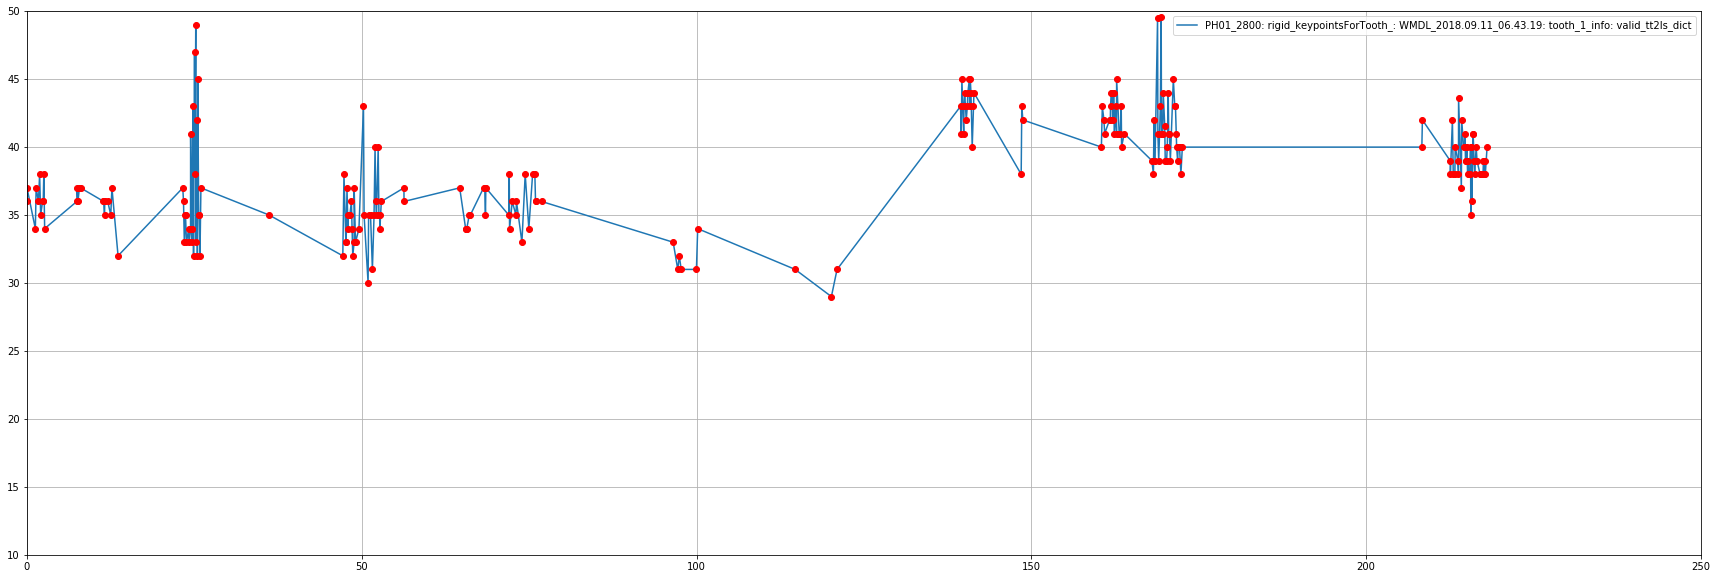

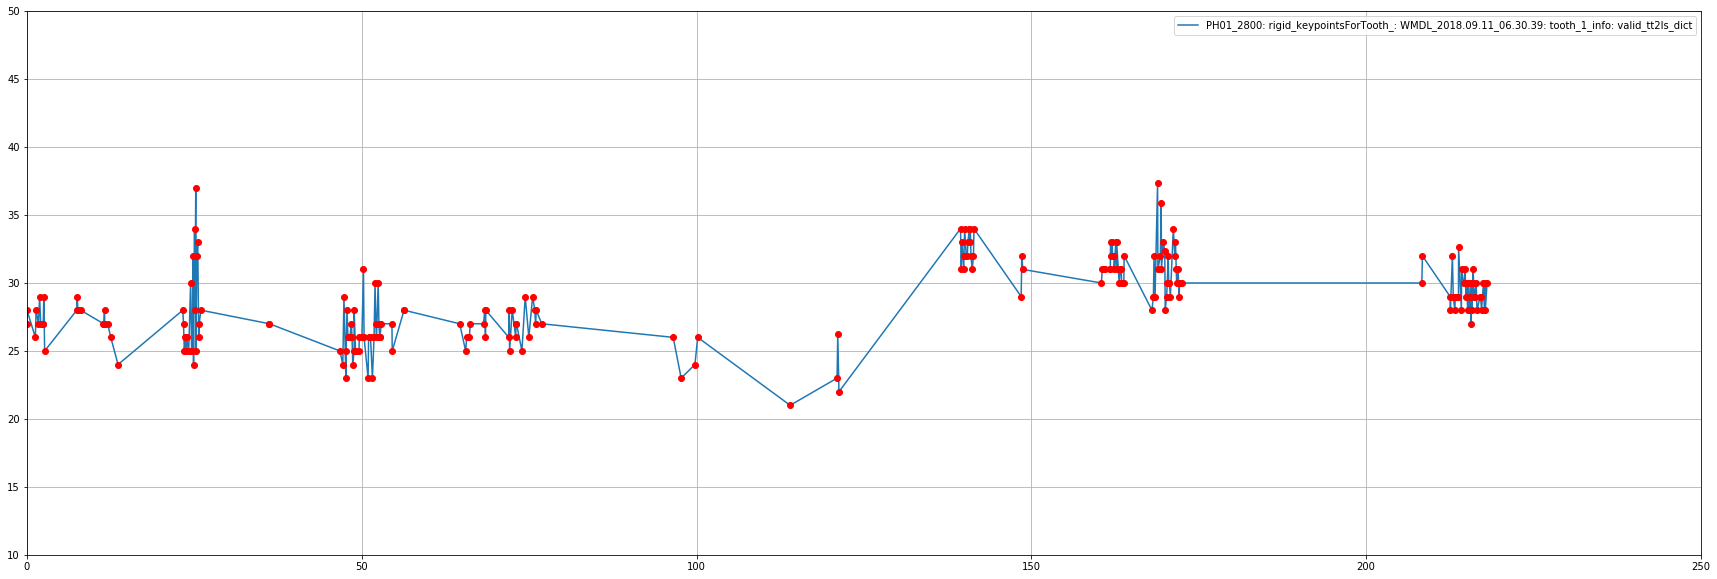

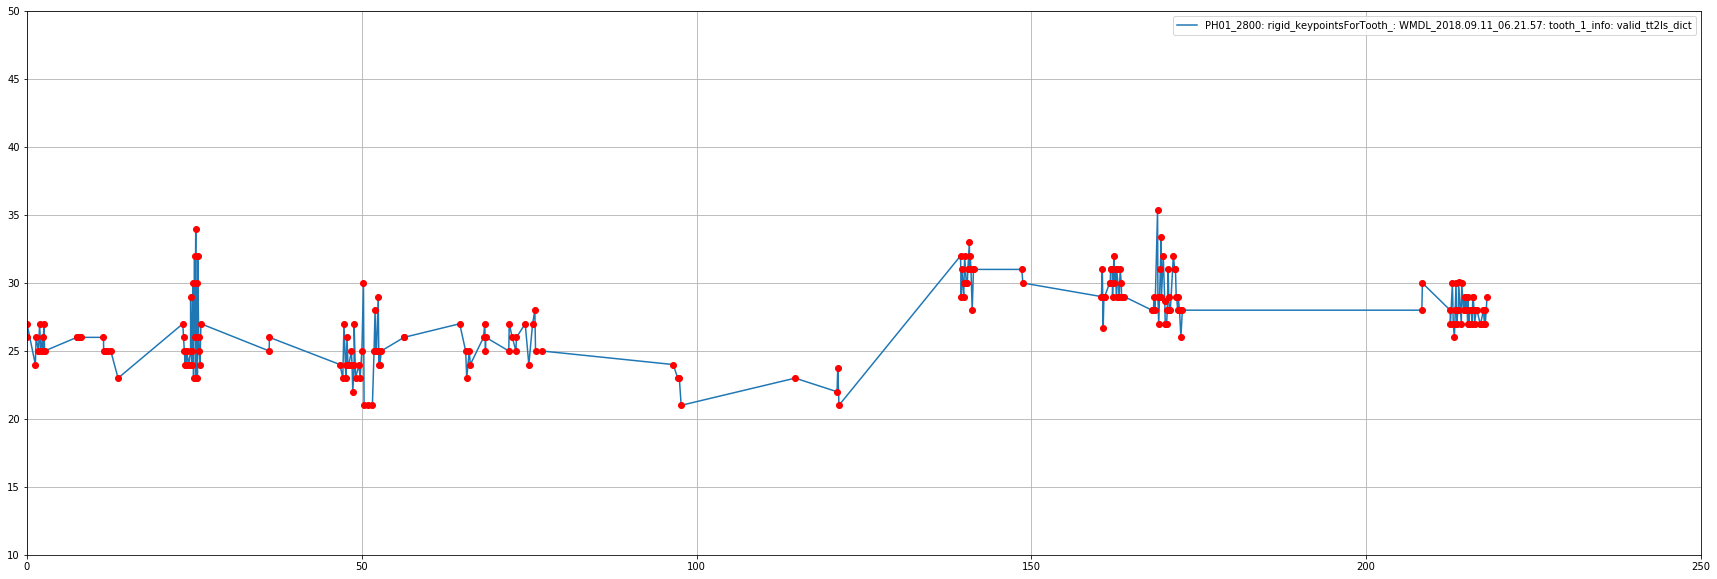

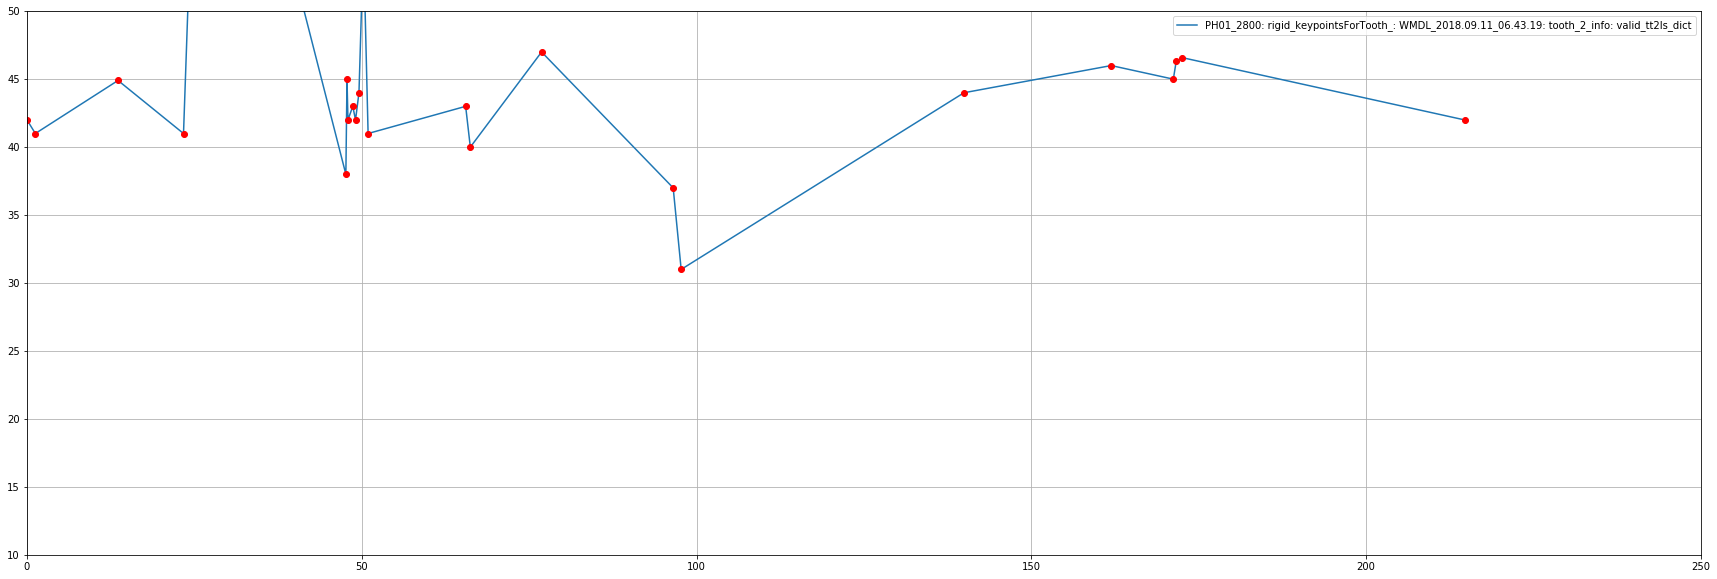

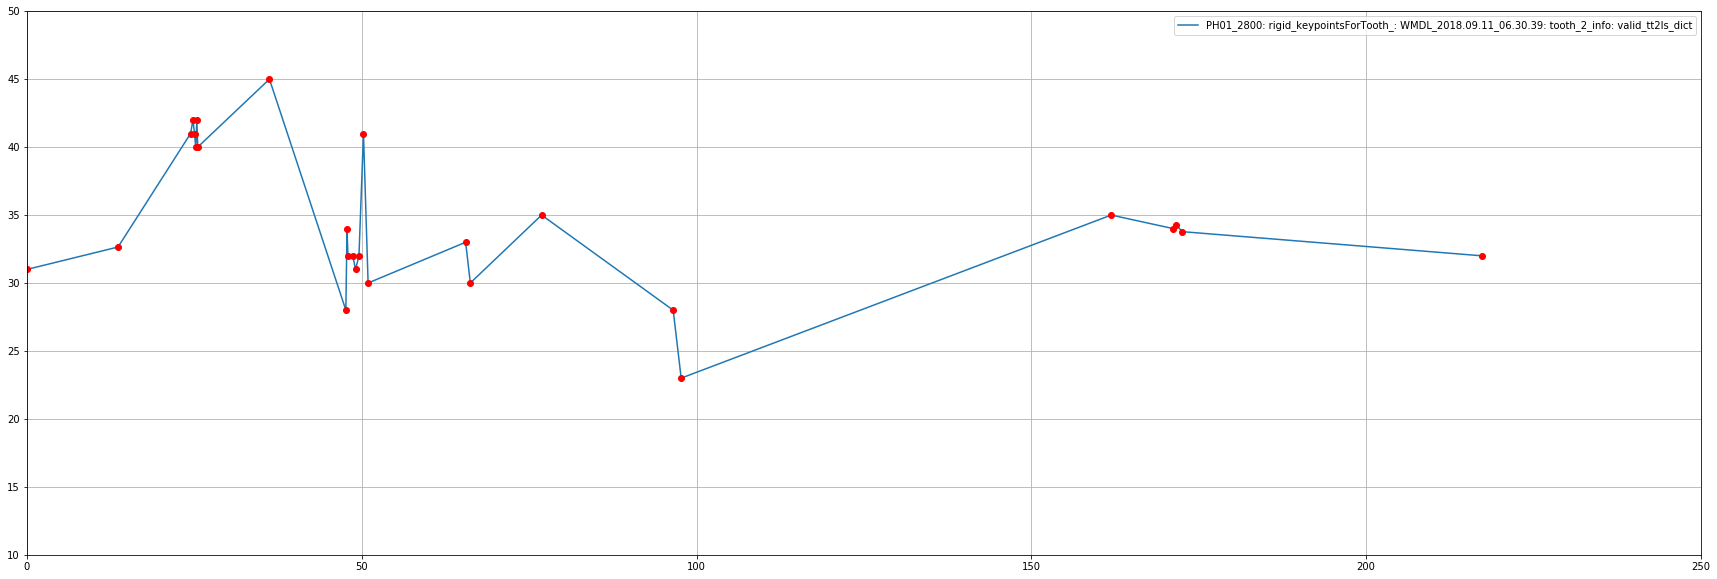

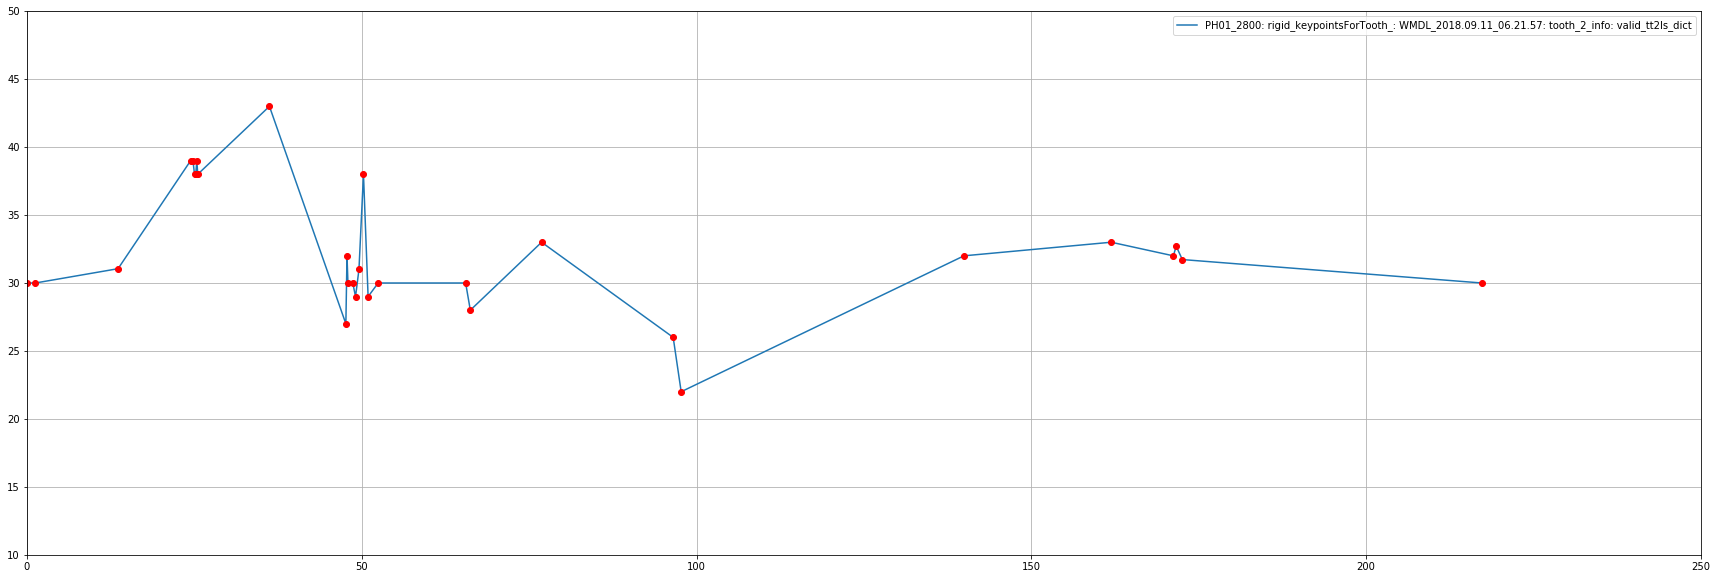

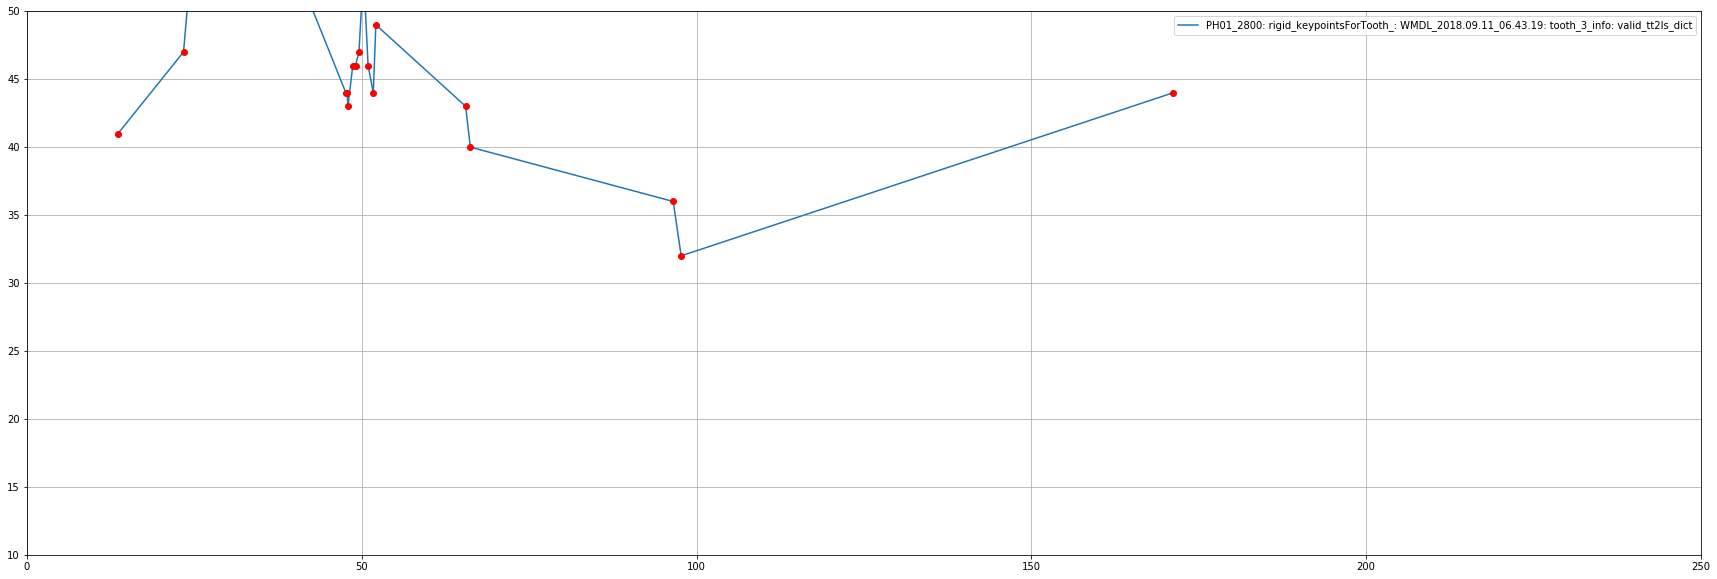

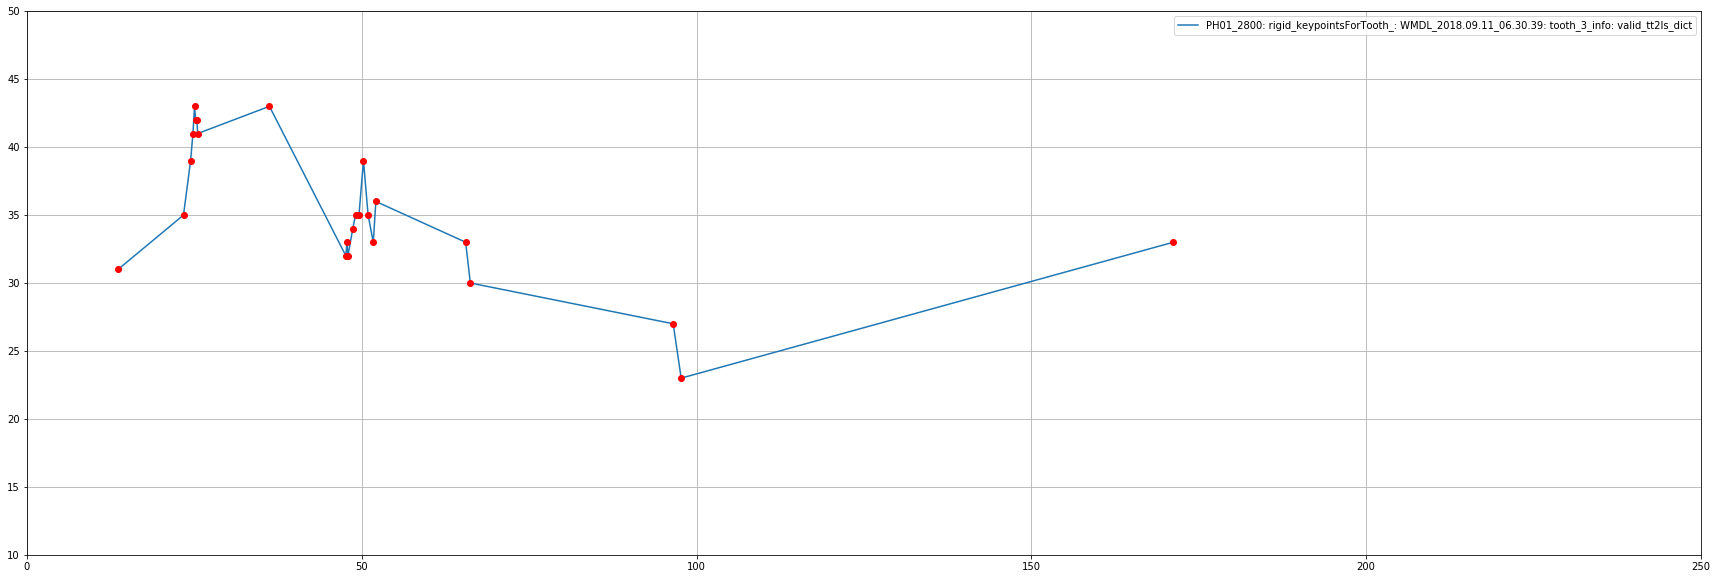

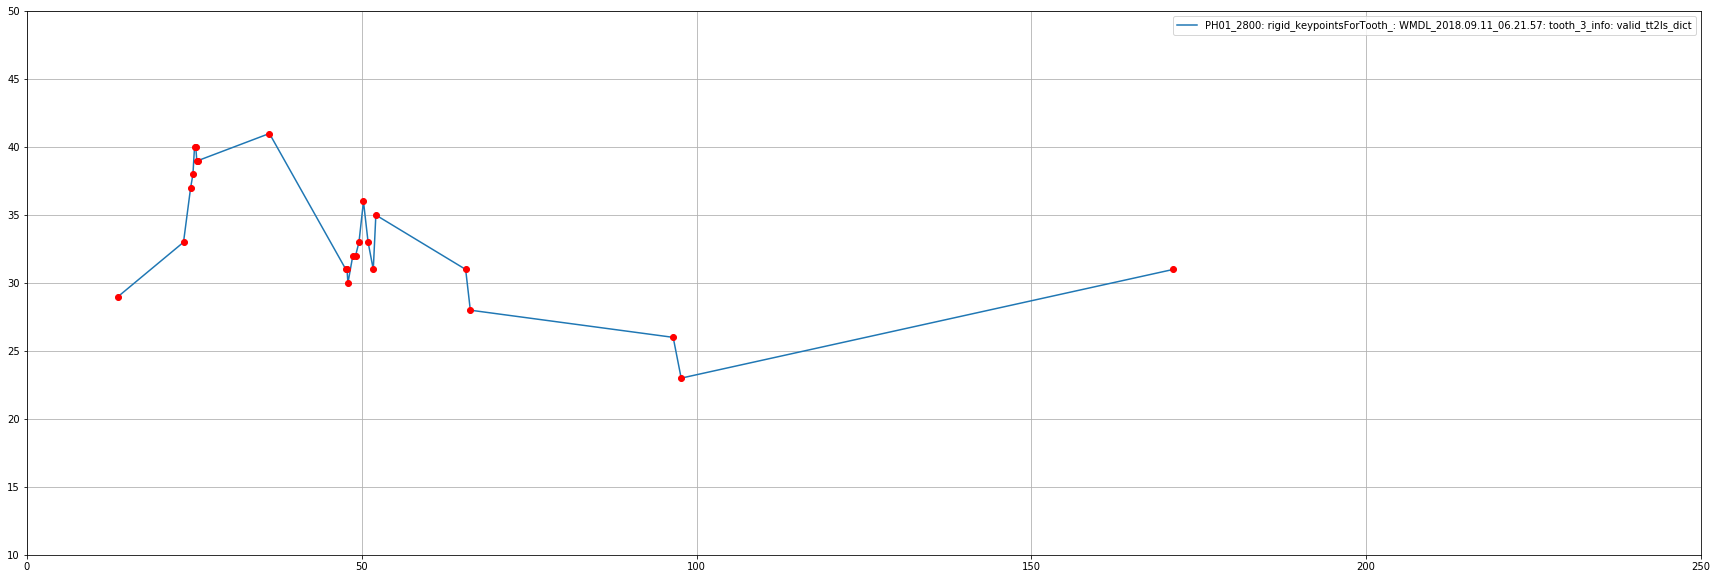

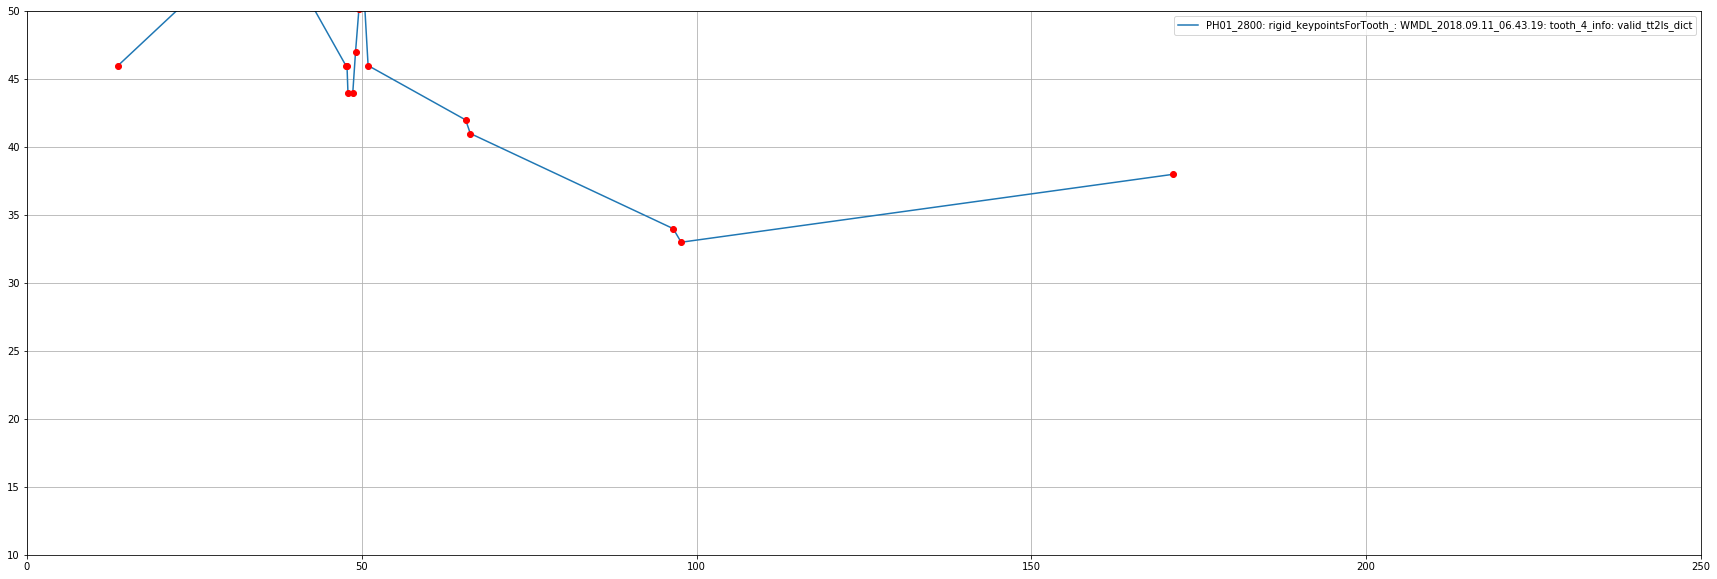

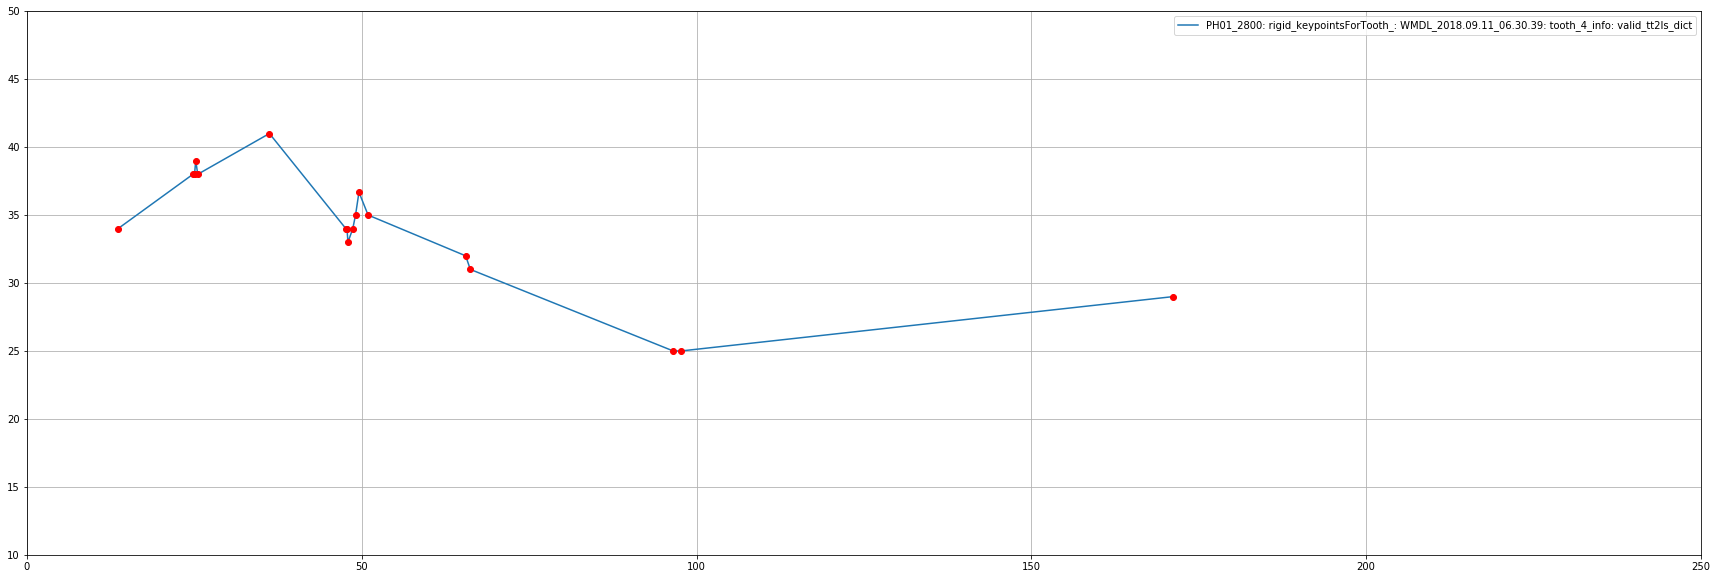

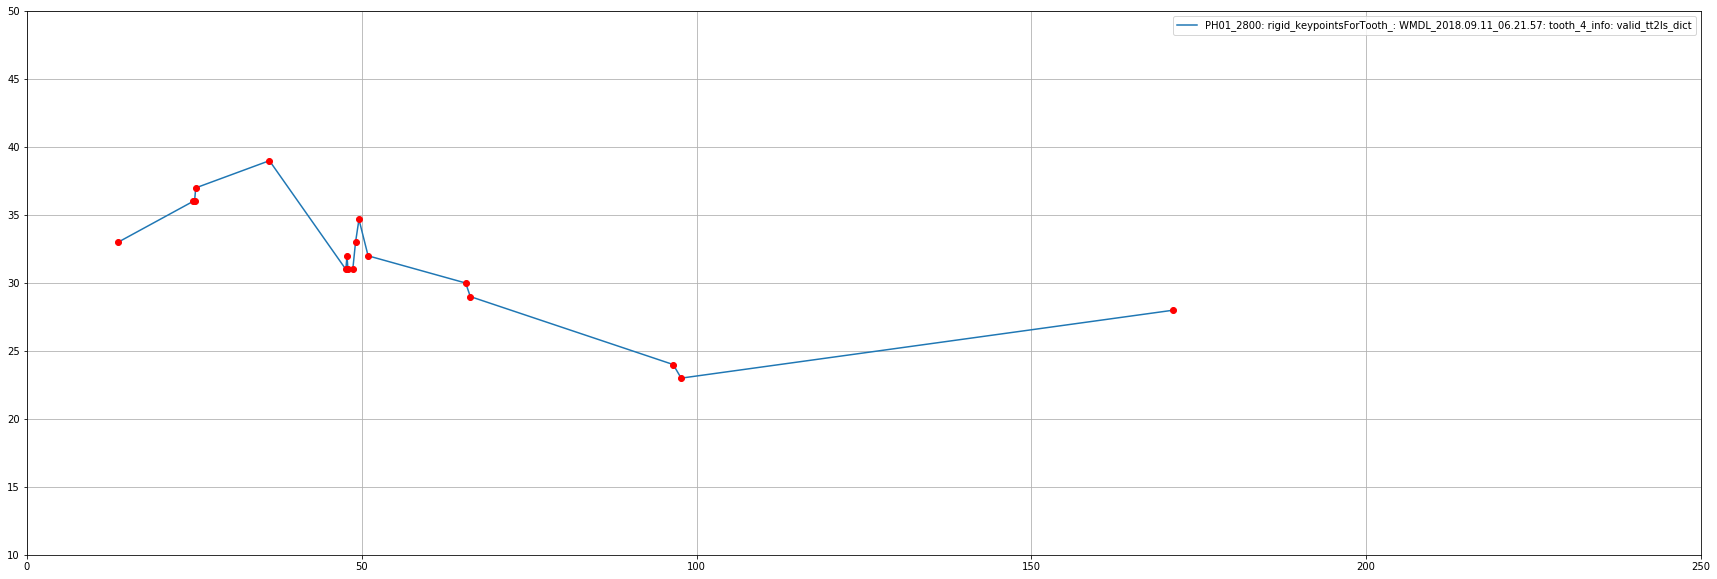

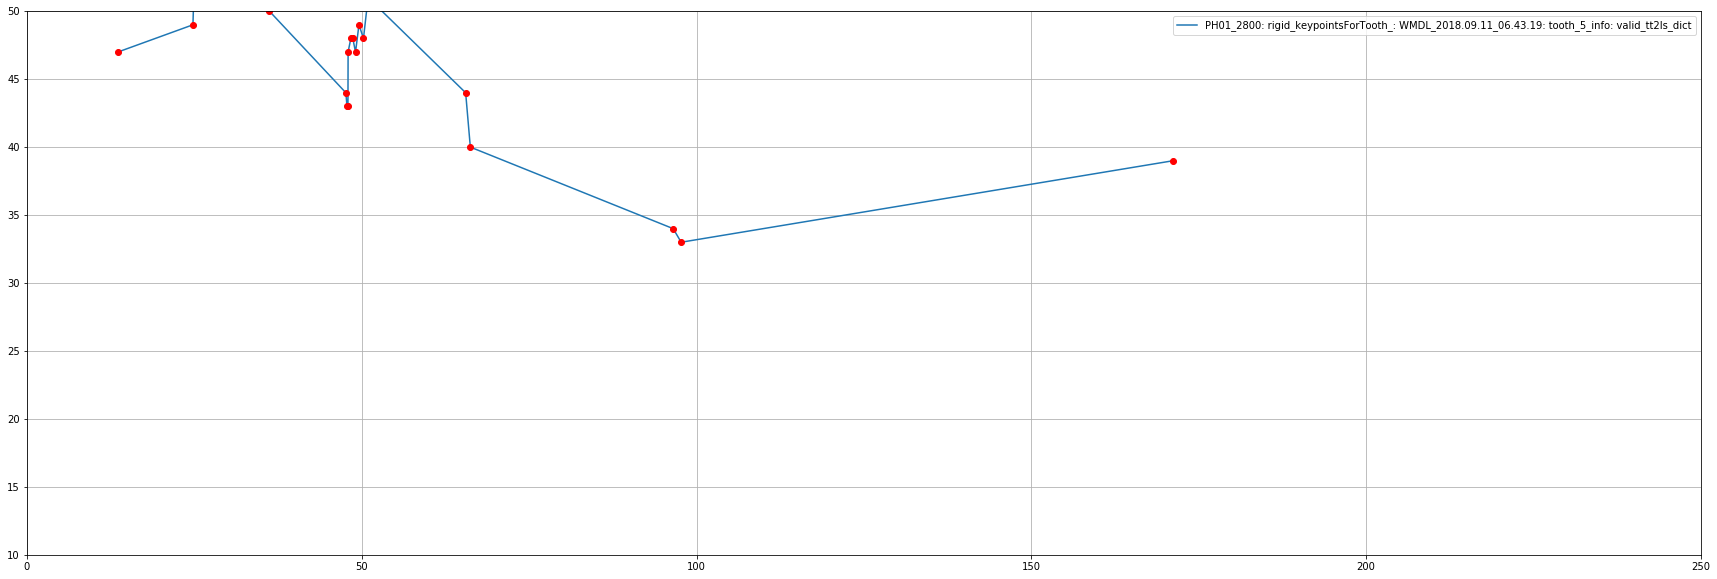

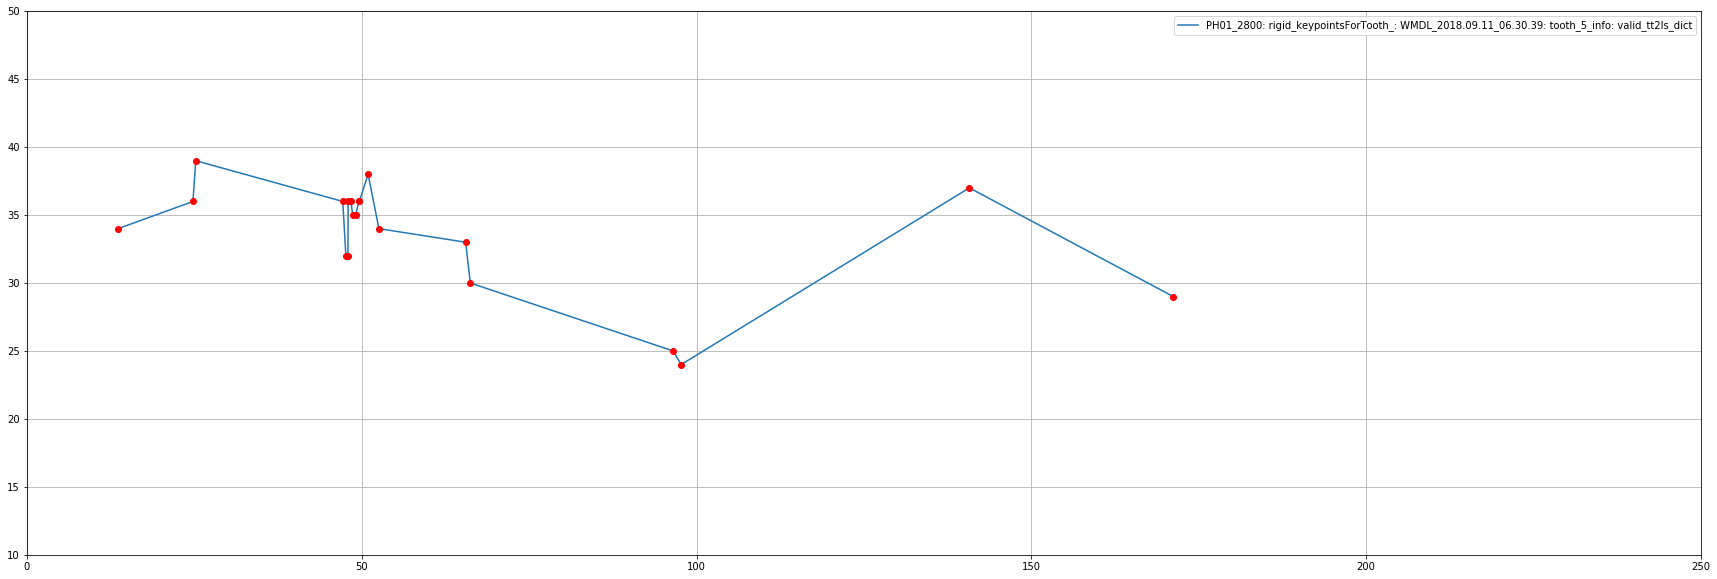

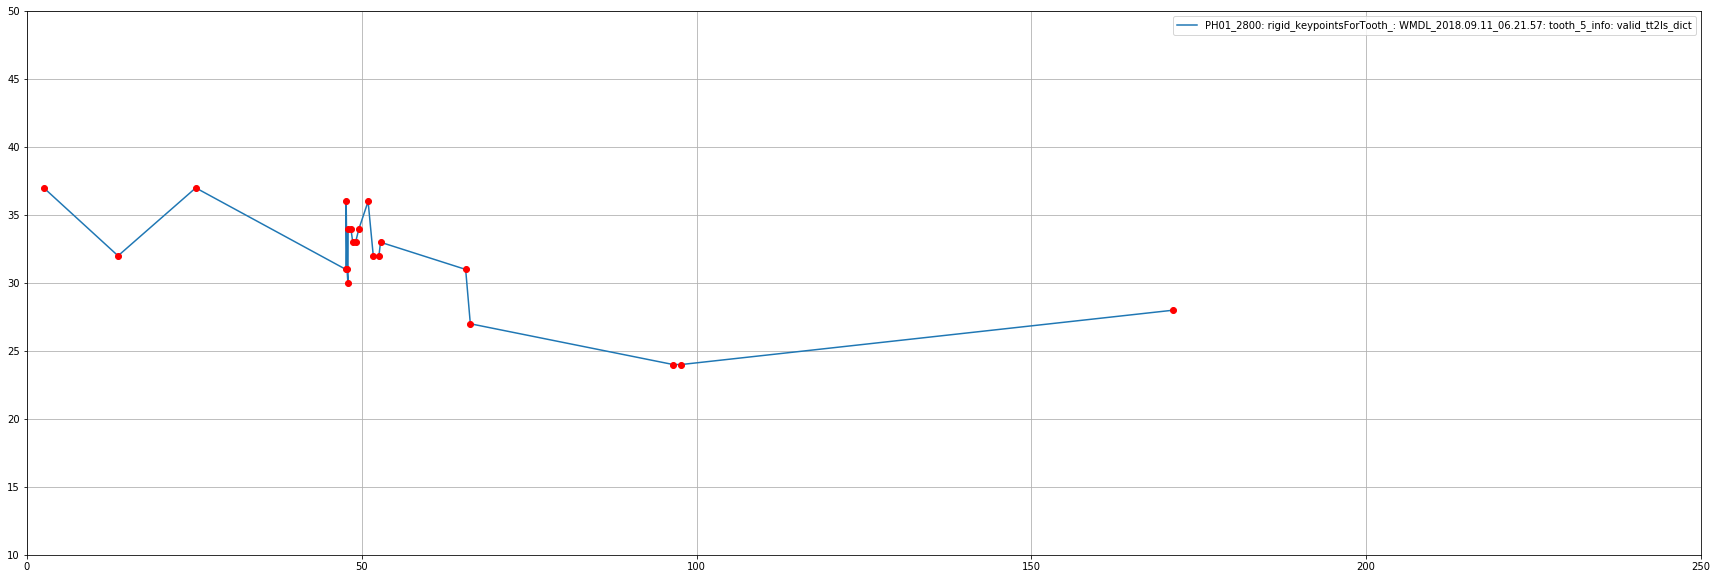

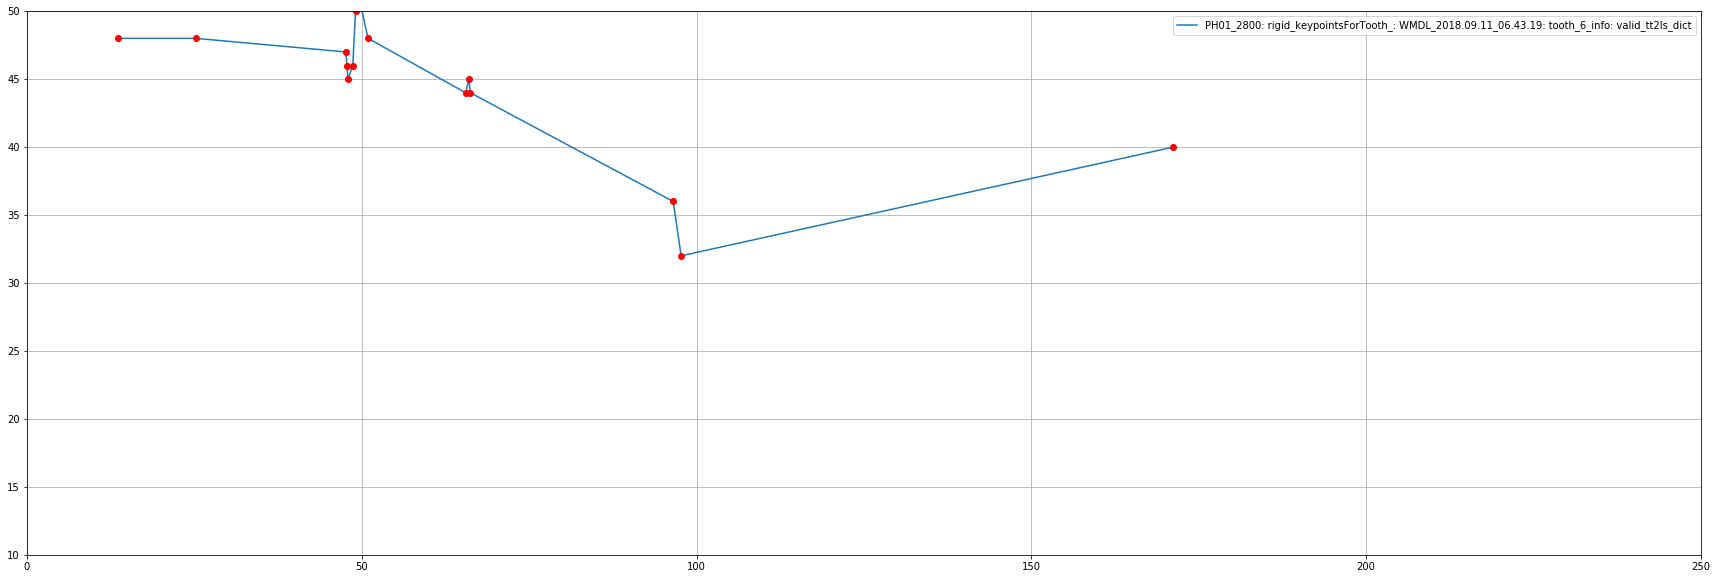

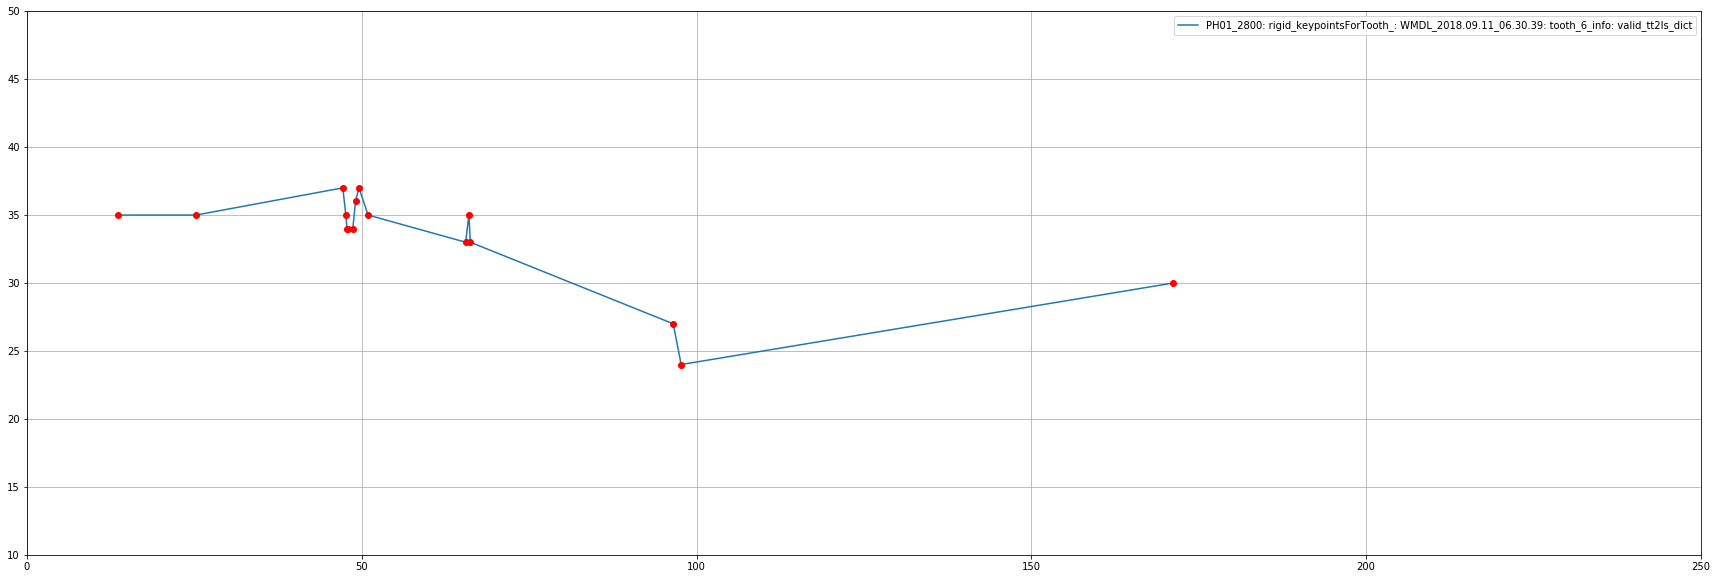

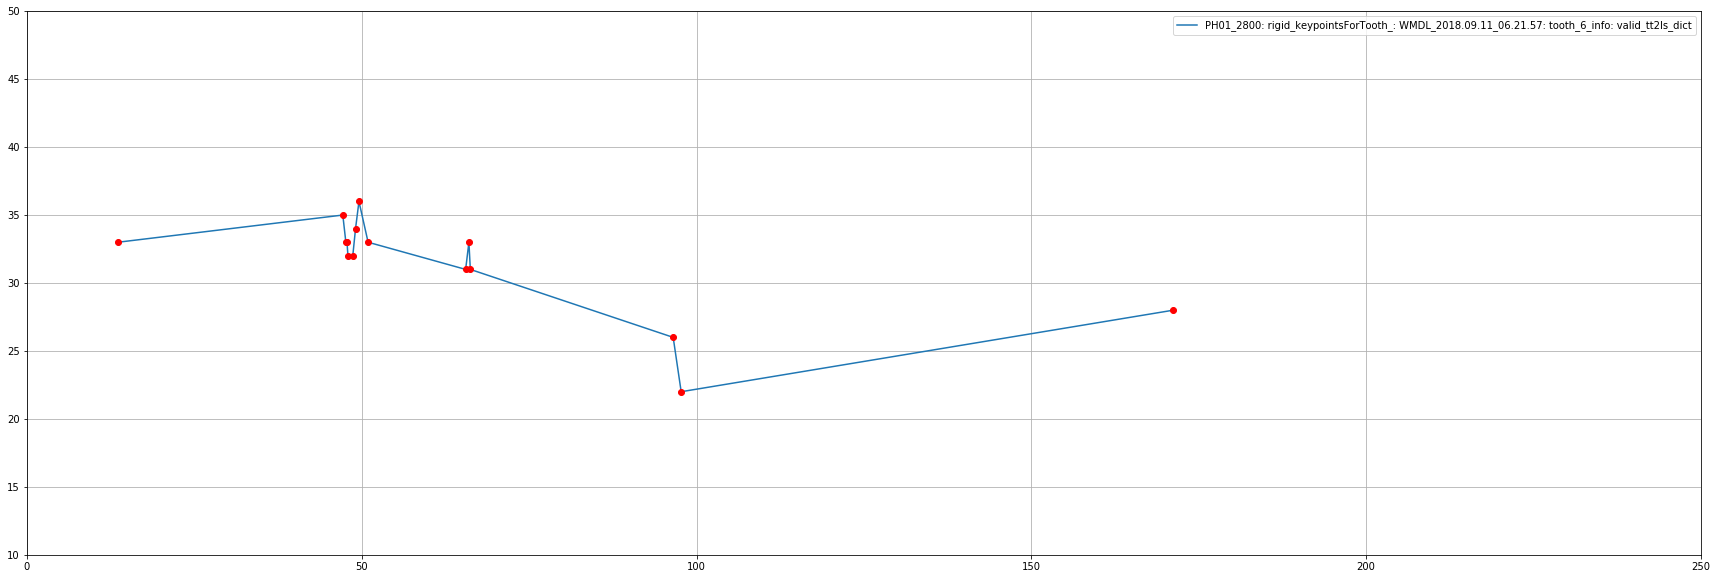

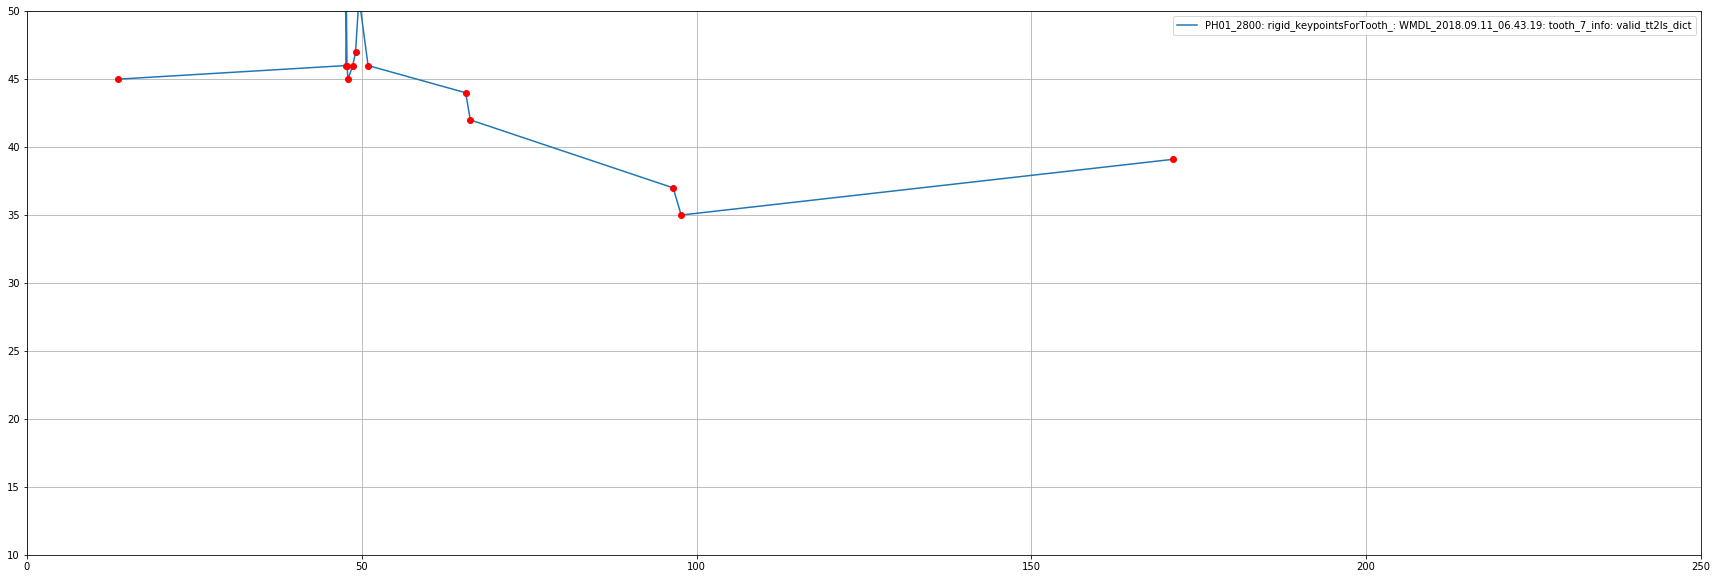

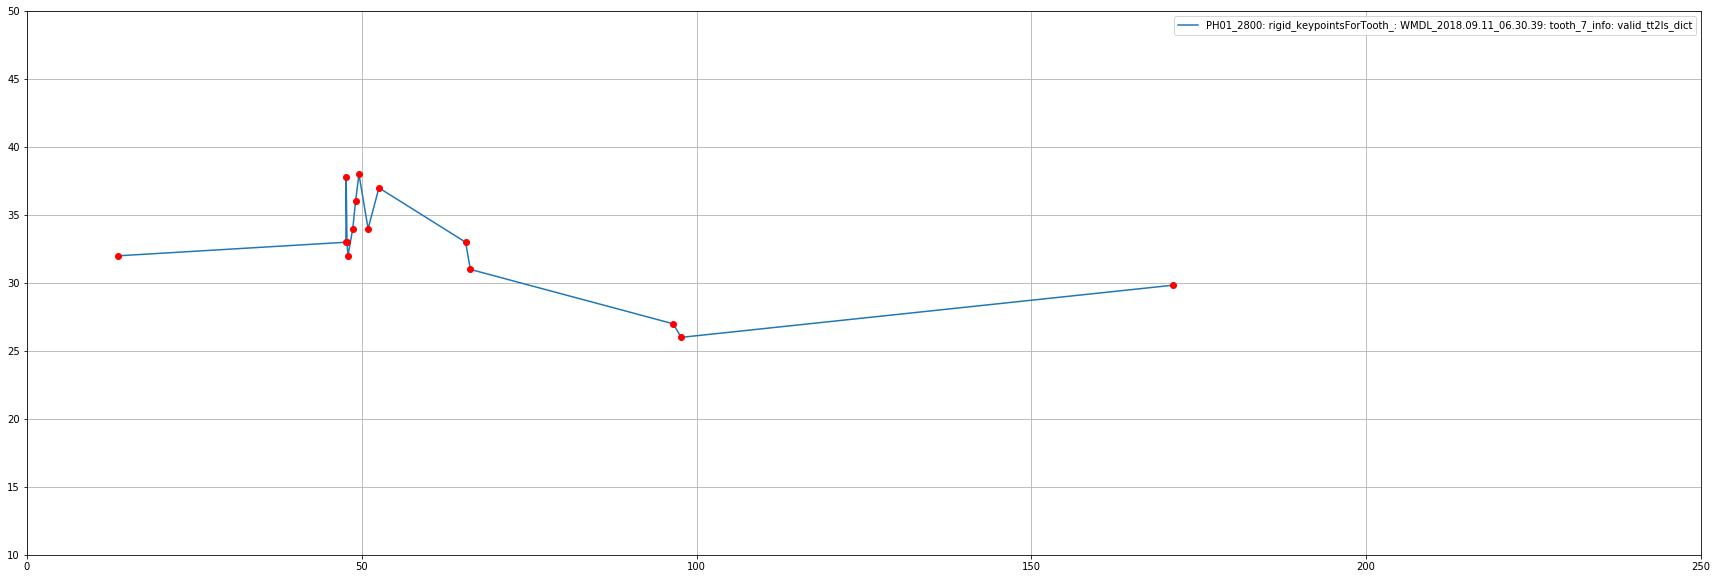

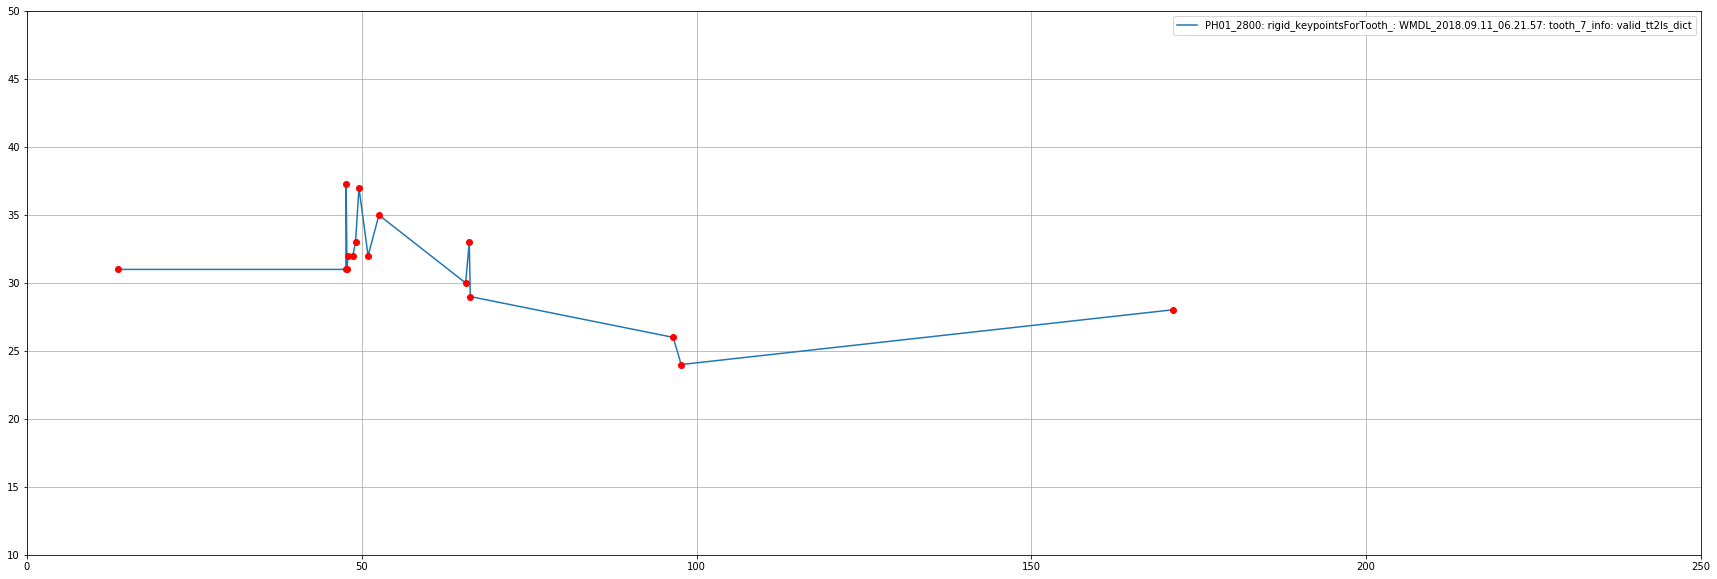

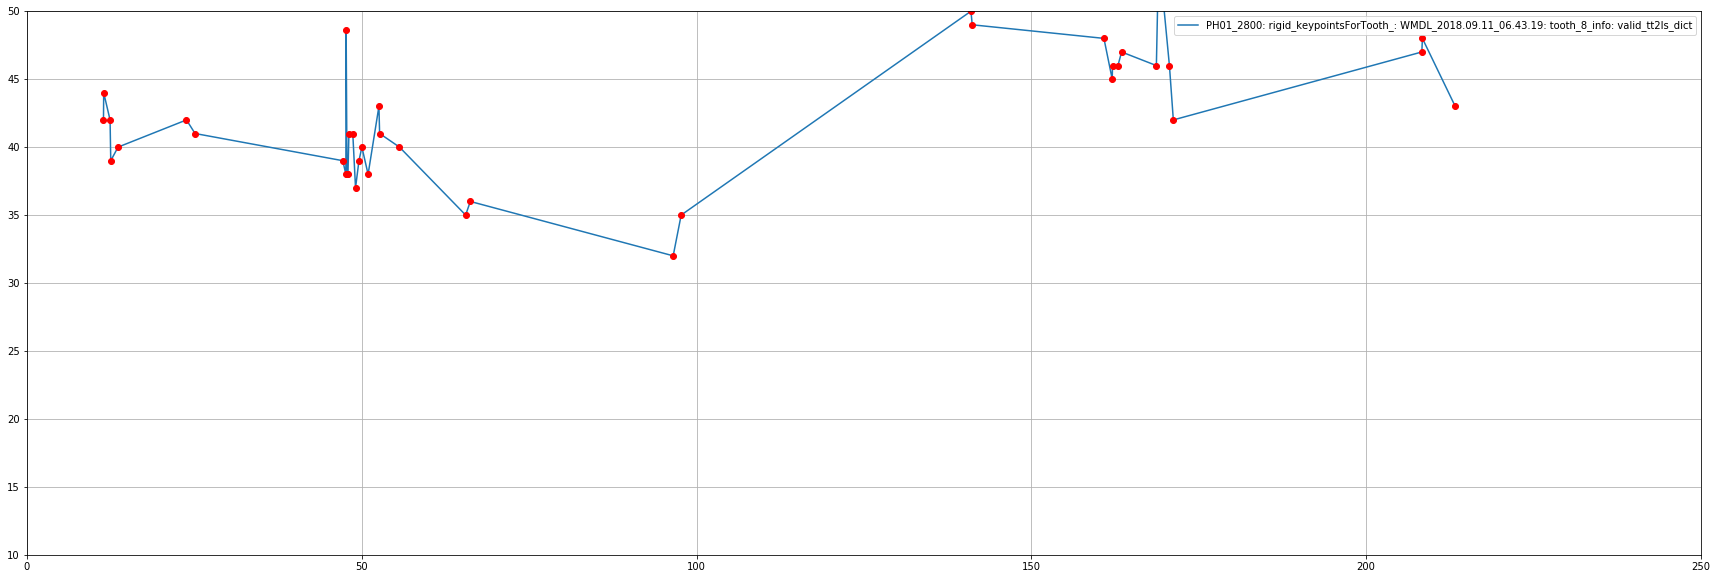

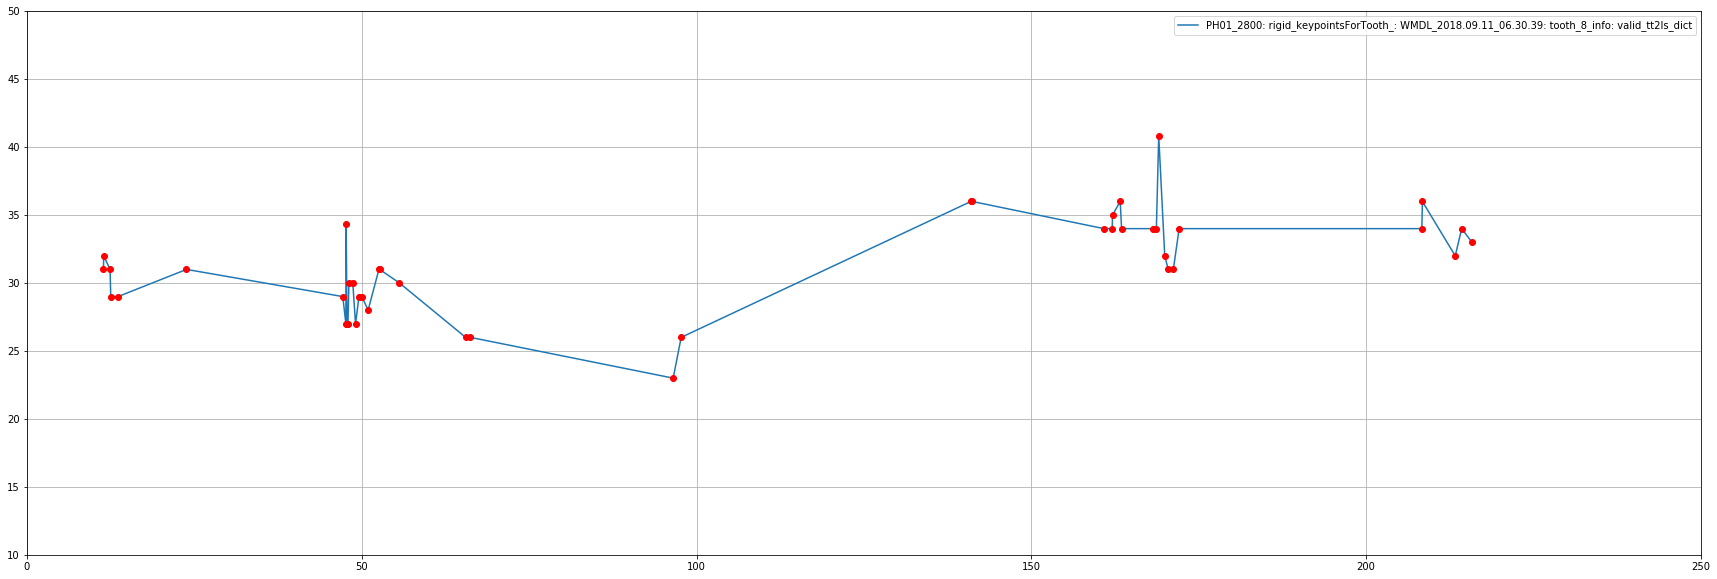

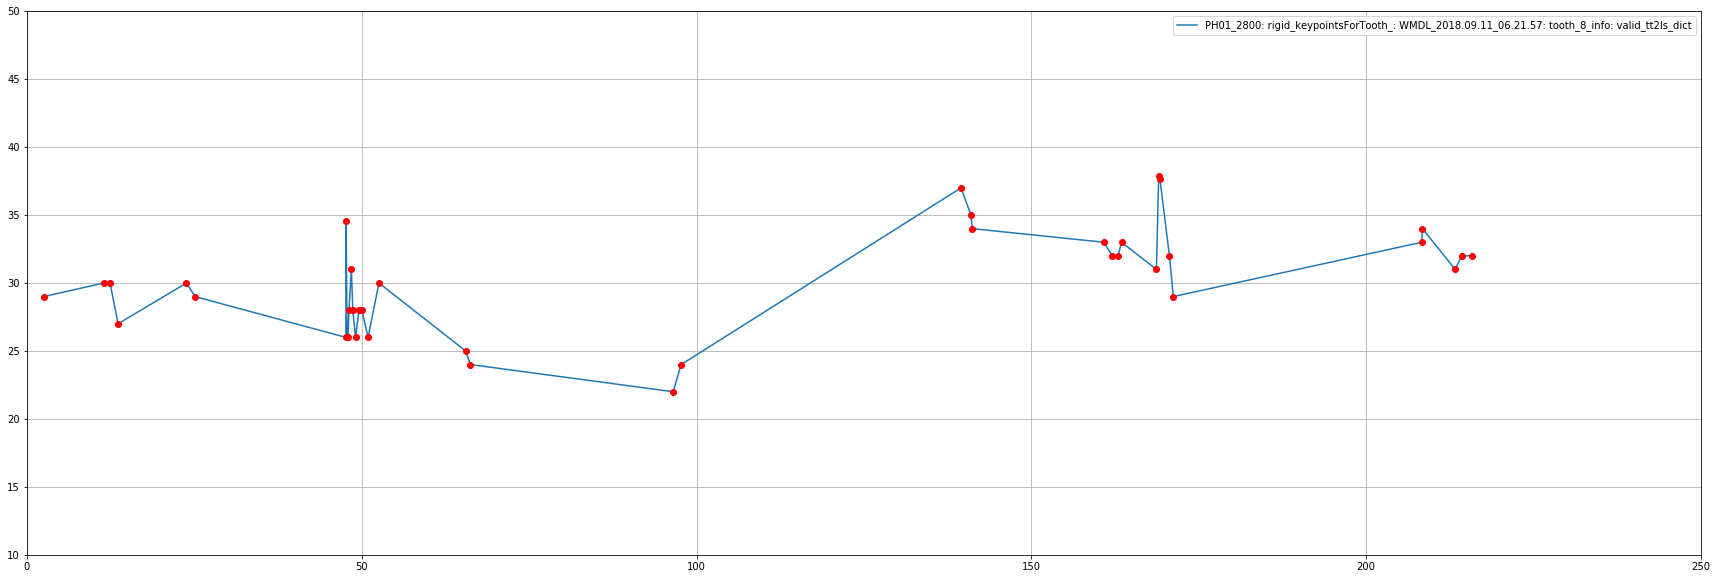

In [83]:
# (excluding smoothed) plot all registered lengths for all teeht and all registeration types and all references

path2savePlots = mainPath + 'finalPlots/'

numberOfTeeth = NUMBER_OF_TEETH
listOfRegTypes = ['rigid_keypointsForTooth_'] #, 'affine_keypointsForTooth_','keypointsForTooth_'
listOfLengthTypes = ['valid_tt2ls_dict']#'all_tt2ls_dict',    ['tt2_ref_ls', 'all_times_list', 'landmarks', 'all_ls2cl_dict', 'all_le2bk_dict', 'all_cl2bk_dict','all_le2cl_dict','all_ls2le_dict','all_ls2bk_dict','all_ls2cl_dict','all_le2bk_dict','all_cl2bk_dict','all_le2cl_dict','all_ls2le_dict', 'all_ls2bk_dict']


for resKey in lengthsAndLandmarksDict.keys():
    
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'
        
        for regTypeKeyWord in listOfRegTypes:
            
            if regTypeKeyWord == 'keypointsForTooth_':

                for infoKey in lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey].keys():
                    if infoKey in listOfLengthTypes:
                        #print('\n' + str(infoKey))

                        plt.figure(figsize=(30,10))
                        #plt.axis([0, 130, 10, 50])
                        plt.axis([0, 250, 10, 50])
                        #plt.axis([0, 70, 30, 60])
                        ax = plt.axes()
                        ax.grid()


                        plt.plot(lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['times'], lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['lengths'], label=str(resKey + ': ' + regTypeKeyWord + ': ' + str(toothNbKey) + ': ' + str(infoKey)))

                        plt.plot(lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['times'], lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['lengths'],'ro')

                        ax.legend()

                        plt.savefig(path2savePlots + str(resKey) + '_' + str(toothNbKey) + '_' + str(infoKey) + '_' + str(regTypeKeyWord) + '.png')

                        #plt.show()

            else:
                for refKey in lengthsAndLandmarksDict[resKey][regTypeKeyWord]:
                    
                    for infoKey in lengthsAndLandmarksDict[resKey][regTypeKeyWord][refKey][toothNbKey].keys():
                        if infoKey in listOfLengthTypes:
                            #print('\n' + str(infoKey))

                            plt.figure(figsize=(30,10))
                            #plt.axis([0, 130, 10, 50])
                            plt.axis([0, 250, 10, 50])
                            #plt.axis([0, 70, 30, 60])
                            ax = plt.axes()
                            ax.grid()


                            plt.plot(lengthsAndLandmarksDict[resKey][regTypeKeyWord][refKey][toothNbKey][infoKey]['times'], lengthsAndLandmarksDict[resKey][regTypeKeyWord][refKey][toothNbKey][infoKey]['lengths'], label=str(resKey + ': ' + regTypeKeyWord + ': '+ refKey + ': ' + str(toothNbKey) + ': ' + str(infoKey)))

                            plt.plot(lengthsAndLandmarksDict[resKey][regTypeKeyWord][refKey][toothNbKey][infoKey]['times'], lengthsAndLandmarksDict[resKey][regTypeKeyWord][refKey][toothNbKey][infoKey]['lengths'],'ro')

                            ax.legend()

                            plt.savefig(path2savePlots + str(resKey) + '_' + str(toothNbKey) + '_' + str(infoKey) + '_' + str(regTypeKeyWord) + '_ref-' + str(refKey) + '.png')

                            #plt.show()
                    

## Image 2 Image Registration

### Method Definitions

In [3]:
def displayXmlPointsOnImage(img, xmlRoot):
    img_name = xmlRoot.find('img_name').text[:-5]
    toothTips = xmlRoot.find('toothTip')
    lipShrouds = xmlRoot.find('lipShroud')
    liftingEyes = xmlRoot.find('liftingEye')
    castLips = xmlRoot.find('castLip')
    bucketLandmarks = xmlRoot.find('bucketLandmark')
    
    displayPointOnImage(img, toothTips, 1)
    displayPointOnImage(img, lipShrouds, 2)
    displayPointOnImage(img, liftingEyes, 3)
    displayPointOnImage(img, castLips, 4)
    displayPointOnImage(img, bucketLandmarks, 5)

In [4]:
def displayPointOnImage(img, points, lmNb):
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    height, width, dim=img.shape
    
    for point in points:
        xcor = int(float(point.get('x')) * width)
        ycor = int(float(point.get('y') )* height)
        
        cv2.circle(img, (xcor, ycor), 5, colors[lmNb-1], -1)

In [5]:
def displayPointsSetOnImage(img, points, color=0):
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    for point in points[0]:
        xcor = point[0]
        ycor = point[1]
        
        cv2.circle(img, (xcor, ycor), 5, colors[color], -1)

In [6]:
def getPointsSet(img, xmlRoot, totalNbOfLandmarks, includeTT):
    counter = 0

    points = np.zeros((1, totalNbOfLandmarks, 2), np.int32)
  
    
    height, width, dim=img.shape
    
    
    lipShrouds = xmlRoot.find('lipShroud')
    liftingEyes = xmlRoot.find('liftingEye')
    castLips = xmlRoot.find('castLip')
    bucketLandmarks = xmlRoot.find('bucketLandmark')
    
    if includeTT:
        toothTips = xmlRoot.find('toothTip')

        for pp in toothTips:
            xcor = int(float(pp.get('x')) * width)
            ycor = int(float(pp.get('y') )* height)
            points[0, counter, 0] = xcor
            points[0, counter, 1] = ycor
            counter+=1
        
    
    for pp in lipShrouds:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for pp in liftingEyes:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for pp in castLips:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for pp in bucketLandmarks:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    return points

In [7]:
def getPointsArray():
    srcAr = []
    trgAr = []

In [8]:
def getPointsSetMiddleTeeth(img, xmlRoot):
    points = np.zeros((1, 20, 2), np.int32)
    counter = 0
    
    height, width, dim=img.shape
    
    toothTips = xmlRoot.find('toothTip')
    lipShrouds = xmlRoot.find('lipShroud')
    liftingEyes = xmlRoot.find('liftingEye')
    castLips = xmlRoot.find('castLip')
    bucketLandmarks = xmlRoot.find('bucketLandmark')
    
    for i in range(len(toothTips)-2):
        pp = toothTips[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for i in range(len(lipShrouds)-2):
        pp = lipShrouds[i+1] 

        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        

    for i in range(len(liftingEyes)-2):
        pp = liftingEyes[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for i in range(len(castLips)-2):
        pp = castLips[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for i in range(len(bucketLandmarks)-2):
        pp = bucketLandmarks[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    return points

In [9]:
def getPointsSetSpecific(img, xmlRoot, keyword):
    height, width, dim=img.shape
    
    landmarks = xmlRoot.find(keyword)
    points = np.zeros((1, len(landmarks), 2), np.int32)
    counter = 0
    
    for pp in landmarks:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
  
    return points

In [62]:
def getRegError(registeredPoints, targetPointSet):
    totalError = 0
    counter = 0
    
    for i in range(len(targetPointSet[0])):
        totalError += getDist(registeredPoints[0][i], targetPointSet[0][i])
        counter+=1
        
    return totalError/counter

In [63]:
def getDist(point1, point2):
    #return abs(point2[0] - point1[0]) + abs(point2[1] - point1[1]) 
    #return math.sqrt(math.pow((point2[0] - point1[0]), 2) + math.pow((point2[1] - point1[1]), 2) )
    return math.sqrt(math.pow((point2[1] - point1[1]), 2) )

### Registering 2 frames

In [ ]:
#Peform FULL image2image registeration on two reference frames 

imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/'

file1 = '1_20161116-074000_0001n0_9767'
file2 = '1_20161116-152500_0001n0_783'

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')

root1 = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()

# Display loaded points on images 
displayXmlPointsOnImage(img1, root1)
displayXmlPointsOnImage(img2, root2)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()





landmarksSet1 = getPointsSet(img1, root1)
landmarksSet2 = getPointsSet(img2, root2)




# Display loaded landmarks on images 
print('landmarksSet1')
print(landmarksSet1[0,1:3,:])
print('landmarksSet2')
print(landmarksSet2[0,1:3,:])

displayPointsSetOnImage(img1, landmarksSet1)
displayPointsSetOnImage(img2, landmarksSet2)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')




# Learn different transformations
transformationRegid5D = cv2.estimateRigidTransform(landmarksSet2, landmarksSet1, False)
transformationRegid6D = cv2.estimateRigidTransform(landmarksSet2, landmarksSet1, True)
transformationHomo, mask = cv2.findHomography(landmarksSet2, landmarksSet1, cv2.RANSAC)




# warp image using learned transformation

transImageRegid5D = cv2.warpAffine(img2, transformationRegid5D,(720, 480))
transImageRegid6D = cv2.warpAffine(img2, transformationRegid6D,(720, 480))
transImageHomo = cv2.warpPerspective(img2, transformationHomo, (720, 480))

plt.imshow(transImageRegid5D)
plt.title('transImageRegid5D')
plt.show()
plt.imshow(transImageRegid6D)
plt.title('transImageRegid6D')
plt.show()
plt.imshow(transImageHomo)
plt.title('transImageHomo')
plt.show()

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')



# Transform the landmark points using learned transformation
transLandmarksRegid5D = cv2.transform(landmarksSet2, transformationRegid5D)
transLandmarksRegid6D = cv2.transform(landmarksSet2, transformationRegid6D)
transLandmarksHomo = cv2.transform(landmarksSet2, transformationHomo)

displayPointsSetOnImage(img1, landmarksSet1, 0)
displayPointsSetOnImage(img1, transLandmarksRegid5D, 1)
displayPointsSetOnImage(img1, transLandmarksRegid6D, 2)


plt.imshow(img1)
plt.show()





# Comparing tooth lengths
print('\nComparing tooth lengths\n')
print('src:')
print(landmarksSet1[0, 9, 1] - landmarksSet1[0, 3, 1])
print('\nTarget:')
print(landmarksSet2[0, 9, 1] - landmarksSet2[0, 3, 1])
print('\nRegid5D:')
print(transLandmarksRegid5D[0, 9, 1] - transLandmarksRegid5D[0, 3, 1])
print('\nRegid6D:')
print(transLandmarksRegid6D[0, 9, 1] - transLandmarksRegid6D[0, 3, 1])
print('\nPerspective:')
print(transLandmarksHomo[0, 9, 1] - transLandmarksHomo[0, 3, 1])




# comparing registeration errors
print('\ncomparing registeration errors\n')
print('\nRegid5D:')
print(getRegError(transLandmarksRegid5D, landmarksSet1))
print('\nRegid6D:')
print(getRegError(transLandmarksRegid6D, landmarksSet1))
print('\nPerspective:')
print(getRegError(transLandmarksHomo, landmarksSet1))

In [ ]:
# Performing FULL row by row registeration between two reference frames

imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/'

file1 = '1_20161116-074000_0001n0_9767'
file2 = '1_20161116-152500_0001n0_783'

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')

root1 = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()

for keyWord in ['toothTip', 'lipShroud', 'liftingEye', 'castLip', 'bucketLandmark']:
    print('\n\n' + keyWord)
    img1 = cv2.imread(imagesPathDir + file1 + '.png')
    pointsSet1 = getPointsSetSpecific(img1, root1, keyWord)
    pointsSet2 = getPointsSetSpecific(img2, root2, keyWord)

    transFormation5D = cv2.estimateRigidTransform(pointsSet2, pointsSet1, False)
    transFormation6D = cv2.estimateRigidTransform(pointsSet2, pointsSet1, True)

    transFormedPoints5D = cv2.transform(pointsSet2, transFormation5D)
    transFormedPoints6D = cv2.transform(pointsSet2, transFormation6D)


    displayPointsSetOnImage(img1, pointsSet1, 0)
    displayPointsSetOnImage(img1, transFormedPoints5D, 1)
    displayPointsSetOnImage(img1, transFormedPoints6D, 2)

    plt.imshow(img1)
    plt.show()


    # comparing registeration errors
    print('\nRegid5D:')
    print(getRegError(transFormedPoints5D, pointsSet1))
    print('\nRegid6D:')
    print(getRegError(transFormedPoints6D, pointsSet1))

In [ ]:
# lean the transformations from other landmarks then move TTs (for two reference images)

imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/referenceFrames/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/referenceFrames/labels/'

file1 = 'WMDL_2018.09.11_06.43.19'
file2 = 'WMDL_2018.09.11_06.21.57'


img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')

root1 = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()


landmarksSet1 = getPointsSet(img1, root1, 32, False)
landmarksSet2 = getPointsSet(img2, root2, 32, False)



# Learn different transformations
transformationRegid5D = cv2.estimateRigidTransform(landmarksSet2, landmarksSet1, False)
transformationRegid6D = cv2.estimateRigidTransform(landmarksSet2, landmarksSet1, True)
transformationHomo, mask = cv2.findHomography(landmarksSet2, landmarksSet1, cv2.RANSAC)



displayPointsSetOnImage(img1, landmarksSet1)
displayPointsSetOnImage(img2, landmarksSet2)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')



# Transform the landmark points using learned transformation. Lower one TT artificially
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()

landmarksSet2Move = getPointsSet(img2, root2, 40, True)
landmarksSet2Move[0][1] += 15  #Lower one TT artificially


transLandmarksRegid5D = cv2.transform(landmarksSet2Move, transformationRegid5D)
transLandmarksRegid6D = cv2.transform(landmarksSet2Move, transformationRegid6D)
transLandmarksHomo = cv2.transform(landmarksSet2Move, transformationHomo)


img1 = cv2.imread(imagesPathDir + file1 + '.png')

displayPointsSetOnImage(img1, transLandmarksRegid5D, 1)

plt.imshow(img1)
plt.title('movedWithRegid')
plt.show()


img1 = cv2.imread(imagesPathDir + file1 + '.png')

displayPointsSetOnImage(img1, transLandmarksRegid6D, 2)

plt.imshow(img1)
plt.title('movedWithAffine')
plt.show()


In [ ]:
# Use 1 row to learn transformation then transform the TT with it

imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/referenceFrames/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/referenceFrames/labels/'

file1 = 'WMDL_2018.09.11_06.43.19'
file2 = 'WMDL_2018.09.11_06.21.57'

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')

root1 = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()



keyWord = 'lipShroud'

pointsSet1 = getPointsSetSpecific(img1, root1, keyWord)
pointsSet2 = getPointsSetSpecific(img2, root2, keyWord)

displayPointsSetOnImage(img2, pointsSet2, 0)
plt.imshow(img2)
plt.title('srcPoints')
plt.show()


transFormation5D = cv2.estimateRigidTransform(pointsSet2, pointsSet1, False)
transFormation6D = cv2.estimateRigidTransform(pointsSet2, pointsSet1, True)


displayPointsSetOnImage(img1, pointsSet1, 0)

img1 = cv2.imread(imagesPathDir + file1 + '.png')
displayPointsSetOnImage(img1, pointsSet1, 0)
displayPointsSetOnImage(img1, pointsSet2, 1)
plt.imshow(img1)
plt.title('red=src, grn=trg')
plt.show()







keyWord = 'toothTip'
pointsSet2 = getPointsSetSpecific(img2, root2, keyWord)

pointsSet2[0][1] += 15 


transFormedPoints5D = cv2.transform(pointsSet2, transFormation5D)
transFormedPoints6D = cv2.transform(pointsSet2, transFormation6D)



print("\nnow transforming TTs\n")

img2 = cv2.imread(imagesPathDir + file2 + '.png')
displayPointsSetOnImage(img2, pointsSet2, 0)
plt.imshow(img2)
plt.title('srcPoints')
plt.show()



img1 = cv2.imread(imagesPathDir + file1 + '.png')
displayPointsSetOnImage(img1, transFormedPoints5D, 1)
plt.imshow(img1)
plt.title('registered 5d')
plt.show()


img1 = cv2.imread(imagesPathDir + file1 + '.png')
displayPointsSetOnImage(img1, transFormedPoints6D, 1)
plt.imshow(img1)
plt.title('registered 6d')
plt.show()

In [ ]:
# (Used for debugging) Registering a test frame to a Refrenece frame (exclude TT in learning transformation)

resKey = 'PH01_2800'
time = 0
numberOfTeeth = 8
numberOfLandmarks = 5

mainPath = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/'

path2RefImage = mainPath + 'referenceFrames/images/WMDL_2018.09.11_06.43.19.png'

path2Reflabel = mainPath + 'referenceFrames/labels/WMDL_2018.09.11_06.43.19_landmarkCoords.xml'

rawFramesDir = mainPath + 'Frame/'



refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)

#visualizeRefDict(refkeyPointsDic, path2RefImage)


fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
inImage = cv2.imread(rawFramesDir + fileName)
refImage = cv2.imread(path2RefImage)


outImage =  draw_all_keypoints_boxes_andCurves(
    inImage,
    finalResultsDict[resKey][time],
    numberOfTeeth=6,
    regTypeKeyword='',
    drawOnlyValidated=True,
    doNotDrawBoxes=True
)

plt.imshow(outImage)
plt.title('validatedPoints_testFrame')
plt.show()



resDicForFrame = finalResultsDict[resKey][time]



############################# Getting the matched landmarks######################################################
srcAr = []
trgAr = []

landmakrsList = ['toothTip_', 'lipShroud_', 'liftingEye_', 'castLip_', 'bucketLandmark_']
for i in range(numberOfLandmarks):
    keypointsKey = 'keypoints_' + str(i + 1 )
    
    if keypointsKey in resDicForFrame:
        keyPoints = resDicForFrame[keypointsKey]

        for j in range(numberOfTeeth):
            if keyPoints[j] in resDicForFrame['validatedKeypoints']:
                
                if i > 0: #do not use toothtip landmarks in calculating transfromation
                    srcAr.append(keyPoints[j])
                    trgAr.append(refkeyPointsDic[landmakrsList[i] + str(j+1)])                   

srcPoints = getRegPointSetFromArray(srcAr)
trgPoints = getRegPointSetFromArray(trgAr)



# Display src landmarks on images 
displayPointsSetOnImage(inImage, srcPoints)

plt.imshow(inImage)
plt.title('matched points refImage')
plt.show()

# reset the inImage
inImage = cv2.imread(rawFramesDir + fileName)


# Display trget landmarks on images 
displayPointsSetOnImage(refImage, trgPoints)

plt.imshow(refImage)
plt.title('matched points refImage')
plt.show()
#################################################################################################################




transformationRegid = cv2.estimateRigidTransform(srcPoints, trgPoints, False)
transformationAffine= cv2.estimateRigidTransform(srcPoints, trgPoints, True)





#################################################################################################################
points2moveAr = []
indexToKeyMap = []


for i in range(numberOfLandmarks):
    keypointsKey = 'keypoints_' + str(i + 1 )
    
    if keypointsKey in resDicForFrame:
        keyPoints = resDicForFrame[keypointsKey]

        for j in range(numberOfTeeth):
            if keyPoints[j] in resDicForFrame['validatedKeypoints']:
                indexToKeyMap.append({'landmarkNb': i, 'toothNb':j})
                points2moveAr.append(keyPoints[j])

                
points2move = getRegPointSetFromArray(points2moveAr)

#*************   lower this landmark to simulate a missing tooth
points2move[0][1] += 20  

###################################### Transforming the points ##################################################
transformedPointsRegid = cv2.transform(points2move, transformationRegid)
transformedPointsAffine = cv2.transform(points2move, transformationAffine)

# Display loaded landmarks on images 
refImage = cv2.imread(path2RefImage)
displayPointsSetOnImage(refImage, transformedPointsRegid)

plt.imshow(refImage)
plt.title('transformedPointsRegid_refImage')
plt.show()


refImage = cv2.imread(path2RefImage)
displayPointsSetOnImage(refImage, transformedPointsAffine)
  
plt.imshow(refImage)
plt.title('transformedPointsAffine_refImage')
plt.show()
#################################################################################################################





##########################3########### warping the images #######################################################
transImageRegid5D = cv2.warpAffine(inImage, transformationRegid,(720, 480))
transImageRegid6D = cv2.warpAffine(inImage, transformationAffine,(720, 480))

plt.imshow(transImageRegid5D)
plt.title('warpedImageRegid5D')
plt.show()
plt.imshow(transImageRegid6D)
plt.title('warpedImageRegid6D')
plt.show()
#################################################################################################################



# Comparing tooth lengths
print('\nComparing tooth lengths\n')
print('src:')
print(srcPoints[0, 9, 1] - srcPoints[0, 3, 1])
print('\nTarget:')
print(trgPoints[0, 9, 1] - trgPoints[0, 3, 1])
print('\nRegid5D:')
print(transformedPointsRegid[0, 9, 1] - transformedPointsRegid[0, 3, 1])
print('\nRegid6D:')
print(transformedPointsAffine[0, 9, 1] - transformedPointsAffine[0, 3, 1])



# comparing registeration errors
print('\n\ncomparing registeration errors')
print('\nRegid5D:')
print(getRegError(transformedPointsRegid, srcPoints))
print('\nRegid6D:')
print(getRegError(transformedPointsAffine, srcPoints))

In [ ]:
# results generator script

# Transform the landmark points using learned transformation
transLandmarksRegid5D = cv2.transform(landmarksSet2, transformationRegid5D)
transLandmarksRegid6D = cv2.transform(landmarksSet2, transformationRegid6D)
transLandmarksHomo = cv2.transform(landmarksSet2, transformationHomo)

displayPointsSetOnImage(img1, landmarksSet1, 0)
displayPointsSetOnImage(img1, transLandmarksRegid5D, 1)
displayPointsSetOnImage(img1, transLandmarksRegid6D, 2)


plt.imshow(img1)
plt.show()

# Comparing tooth lengths
print('src:')
print(landmarksSet1[0, 9, 1] - landmarksSet1[0, 3, 1])
print('\nTarget:')
print(landmarksSet2[0, 9, 1] - landmarksSet2[0, 3, 1])
print('\nRegid5D:')
print(transLandmarksRegid5D[0, 9, 1] - transLandmarksRegid5D[0, 3, 1])
print('\nRegid6D:')
print(transLandmarksRegid6D[0, 9, 1] - transLandmarksRegid6D[0, 3, 1])
print('\nPerspective:')
print(transLandmarksHomo[0, 9, 1] - transLandmarksHomo[0, 3, 1])


print('\n\nerrors:')

# comparing registeration errors
print('\nRegid5D:')
print(getRegError(transLandmarksRegid5D, landmarksSet1))
print('\nRegid6D:')
print(getRegError(transLandmarksRegid6D, landmarksSet1))
print('\nPerspective:')
print(getRegError(transLandmarksHomo, landmarksSet1))

## For presentation

In [ ]:
#get the total number of each landmark we detect in this set

resKey = 'PH01_2800'

landmarksCountDic = {}
for i in range(NUMBER_OF_TEETH):
    ttCount = 0
    lsCount = 0
    leCount = 0
    clCount = 0
    bkCount = 0
    
    for time in sorted(paresedResultsDict[resKey].keys()):
        if 'keypointsForTooth_' + str(i+1) in paresedResultsDict[resKey][time].keys():
            keyPoints = paresedResultsDict[resKey][time]['keypointsForTooth_' + str(i+1)]

            if keyPoints[0][0] > 1 and  keyPoints[0][1] > 1:
                ttCount += 1

            if keyPoints[1][0] > 1 and  keyPoints[1][1] > 1:
                lsCount += 1

            if keyPoints[2][0] > 1 and  keyPoints[2][1] > 1:
                leCount += 1

            if keyPoints[3][0] > 1 and  keyPoints[3][1] > 1:
                clCount += 1

            if keyPoints[4][0] > 1 and  keyPoints[4][1] > 1:
                bkCount += 1
    
    landmarksCountDic['tooth_' + str(i+1)] = {'ttCount':ttCount,'lsCount':lsCount, 'leCount':leCount, 'clCount':clCount, 'bkCount':bkCount}
        
print(landmarksCountDic)
print('\n\n')

totalNbOfLogs = len(paresedResultsDict[resKey].keys())
landmarksCountDicPerc = deepcopy(landmarksCountDic)
for k1 in landmarksCountDicPerc.keys():
    for k2 in landmarksCountDicPerc[k1].keys():
        landmarksCountDicPerc[k1][k2] = landmarksCountDicPerc[k1][k2] / totalNbOfLogs
        
print(landmarksCountDicPerc)

### Smoothing Lengths

In [ ]:
# Pre-process for smoothing (this adds mooth dict, which stores the lengths using all refs, for each point)

numberOfTeeth = NUMBER_OF_TEETH
listOfRegTypes = ['rigid_keypointsForTooth_']

for resKey in lengthsAndLandmarksDict.keys():
    
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'
        lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_lengths'] = {}
        
        for timeStep in sorted(lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_times']):
            
            if timeStep not in lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_lengths'].keys():
                lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_lengths'][timeStep] = []
                
            for regTypeKeyWord in listOfRegTypes:

                for refKey in references2use:
                    if refKey in lengthsAndLandmarksDict[resKey]['forSmoothing']\
                    [toothNbKey][regTypeKeyWord].keys():
                        
                        if timeStep in lengthsAndLandmarksDict[resKey]['forSmoothing']\
                        [toothNbKey][regTypeKeyWord][refKey].keys():
                            
                            lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_lengths'][timeStep].append(lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey][regTypeKeyWord][refKey][timeStep])

In [ ]:
# calculating the std of lengths 

import statistics 

numberOfTeeth = NUMBER_OF_TEETH
regTypeKeyWord = 'rigid_keypointsForTooth_'
infoKey =  'all_tt2ls_dict'

for resKey in lengthsAndLandmarksDict.keys():
    print(resKey)
    
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'

        for refKey in references2use:
            print(str(toothNbKey) + '  --' + str(refKey) + '\n')

            stdB = statistics.stdev(lengthsAndLandmarksDict[resKey][regTypeKeyWord][refKey][toothNbKey][infoKey]['lengths'])
            stdA = statistics.stdev(lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey][regTypeKeyWord][refKey].values())

            if not stdB == stdA:
                print("std BEFORE smoothing is: " + str(stdB))
                print("std AFTER  smoothing is: " + str(stdA))
            else:
                print("std both Before and After smoothing is: " + str(stdA))
                print('\n\n')
            
            
            

'''
listOfRegTypes = ['rigid_keypointsForTooth_','keypointsForTooth_'] #, 'affine_keypointsForTooth_'
listOfLengthTypes = ['all_tt2ls_dict', 'valid_tt2ls_dict', 'tt2_ref_ls']#['all_times_list', 'landmarks', 'all_ls2cl_dict', 'all_le2bk_dict', 'all_cl2bk_dict','all_le2cl_dict','all_ls2le_dict','all_ls2bk_dict','all_ls2cl_dict','all_le2bk_dict','all_cl2bk_dict','all_le2cl_dict','all_ls2le_dict', 'all_ls2bk_dict']


for resKey in lengthsAndLandmarksDict.keys():
    
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'
        
        for regTypeKeyWord in listOfRegTypes:

            for infoKey in lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey].keys():
                if infoKey in listOfLengthTypes:
                
                    print('\n' + str(resKey + ': ' + regTypeKeyWord + ': ' + str(toothNbKey) + ': ' + str(infoKey)))
                    
                    std = statistics.stdev(lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['lengths'])
                    
                    print("Calculated std is: " + str(std) + '\n')
'''

In [ ]:
# Look at the number of points for each ref, before and after smoothing

for resKey in lengthsAndLandmarksDict.keys():
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'
        
        print(toothNbKey)
        
        for refKey in references2use:
            print('\nnumber of time steps for ref:  ' + refKey)
            print('BEFORE smoothing:')
            print(len(lengthsAndLandmarksDict[resKey]['rigid_keypointsForTooth_'][refKey][toothNbKey]['all_tt2ls_dict']['lengths']))
            print('AFTER smoothing:')
            print(len(lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['rigid_keypointsForTooth_'][refKey].keys()))
            
        print('\n\n\n\n\n***********************************************')
            
            



In [ ]:
# test out the final number of points for each time step (you should only have as many points as you have refs)

for resKey in lengthsAndLandmarksDict.keys():
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'
        
        print('for:  ' + toothNbKey)
        
        for key in sorted(lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_lengths'].keys()):
            finalNbPointsForEachTimeStamp = len(lengthsAndLandmarksDict[resKey]['forSmoothing'][toothNbKey]['all_lengths'][key])

            if finalNbPointsForEachTimeStamp < len(references2use):
                print('for timeStep:  ' + str(key) + '  we have  ' + str(finalNbPointsForEachTimeStamp) + '   points but were expecting  ' + str(len(references2use)) +'  since that is the number of referenceFrames we registered to.')
                
                
        print('\n\n\n\n\n***********************************************')

In [ ]:
# Look at the values of different refs

for resKey in lengthsAndLandmarksDict.keys():
    for i in range(numberOfTeeth):
        toothNbKey = 'tooth_' + str(i + 1) + '_info'
        
        print('for:  ' + toothNbKey)
        
        for refKey in references2use:

            print(refKey)

            if len(lengthsAndLandmarksDict[resKey]['rigid_keypointsForTooth_'][refKey][toothNbKey]['all_tt2ls_dict']['lengths']) > 0:


                print(lengthsAndLandmarksDict[resKey]['rigid_keypointsForTooth_'][refKey][toothNbKey]['all_tt2ls_dict']['lengths'][0])
                print(lengthsAndLandmarksDict[resKey]['rigid_keypointsForTooth_'][refKey][toothNbKey]['all_tt2ls_dict']['times'][0])


            else:
                print('*** IS EMPTY ***')


            print()
            
            
        print('\n\n\n\n\n***********************************************')

# <font color='red'> Sandbox Area (DO NOT DELETE)

In [46]:
minAllowedRatiosDict

{'tooth_1': {'minAllowed_tt2ls_over_cl2bk': 2.25,
  'minAllowed_tt2ls_over_le2bk': 0.4476190476190477,
  'minAllowed_tt2ls_over_le2cl': 0.66875,
  'minAllowed_tt2ls_over_ls2bk': 0.3181818181818181,
  'minAllowed_tt2ls_over_ls2cl': 0.4611111111111111,
  'minAllowed_tt2ls_over_ls2le': 1.7192307692307691},
 'tooth_2': {'minAllowed_tt2ls_over_cl2bk': 1.95,
  'minAllowed_tt2ls_over_le2bk': 0.5956521739130435,
  'minAllowed_tt2ls_over_le2cl': 1.0166666666666666,
  'minAllowed_tt2ls_over_ls2bk': 0.43333333333333335,
  'minAllowed_tt2ls_over_ls2cl': 0.6772727272727272,
  'minAllowed_tt2ls_over_ls2le': 2.2357142857142858},
 'tooth_3': {'minAllowed_tt2ls_over_cl2bk': 2.3785714285714286,
  'minAllowed_tt2ls_over_le2bk': 0.6391304347826087,
  'minAllowed_tt2ls_over_le2cl': 1.0125,
  'minAllowed_tt2ls_over_ls2bk': 0.4666666666666667,
  'minAllowed_tt2ls_over_ls2cl': 0.6891304347826086,
  'minAllowed_tt2ls_over_ls2le': 2.3785714285714286},
 'tooth_4': {'minAllowed_tt2ls_over_cl2bk': 1.83888888888888

In [ ]:
# Plotting original lengths from filteredResultsDict 

path2savePlots = mainPath + 'finalPlots/'

numberOfTeeth = NUMBER_OF_TEETH

for i in range(numberOfTeeth):
    toothLandmarkKey = 'keypointsForTooth_' + str(i + 1)
    
    lengths = []
    times = []
    
    for time in sorted(filteredResultsDict['PH01_2800'].keys()):
        times.append(time)
        
        length = filteredResultsDict['PH01_2800'][time][toothLandmarkKey][1][1] - filteredResultsDict['PH01_2800'][time][toothLandmarkKey][0][1]
        lengths.append(length)
    


    plt.figure(figsize=(30,10))
    plt.axis([0, 250, 10, 50])
    ax = plt.axes()
    ax.grid()


    plt.plot(times, lengths, label='originalLengths for tooth: ' + str(i + 1))

    plt.plot(times, lengths,'ro')

    ax.legend()

    plt.savefig(path2savePlots + 'originalLengths_tooth' + str(i + 1)  + '.png')

    #plt.show()



### Investigating different points on a length plot

In [53]:
lengthsAndLandmarksDict['PH01_2800'].keys()

dict_keys(['keypointsForTooth_', 'rigid_keypointsForTooth_', 'forSmoothing'])

In [52]:
lengthsAndLandmarksDict['wmdlLogs_aitik']['rigid_keypointsForTooth_'].keys()

dict_keys(['WMDL_2017.11.27_23.58.12', 'WMDL_2017.11.28_00.33.32'])

In [54]:
lengthsAndLandmarksDict['PH01_2800']['rigid_keypointsForTooth_']['WMDL_2018.09.11_06.21.57'].keys()

dict_keys(['tooth_3_info', 'tooth_1_info', 'tooth_5_info', 'tooth_6_info', 'tooth_8_info', 'tooth_7_info', 'tooth_4_info', 'tooth_2_info'])

In [108]:
lengthsAndLandmarksDict['PH02_2800']['rigid_keypointsForTooth_']['WMDL_2017.11.28_00.33.32']['tooth_5_info'].keys()

dict_keys(['all_cl2bk_dict', 'landmarks', 'all_ls2le_dict', 'all_ls2cl_dict', 'all_tt2ls_dict', 'all_times_list', 'valid_tt2ls_dict', 'tt2_ref_ls', 'all_le2bk_dict', 'all_le2cl_dict', 'all_ls2bk_dict'])

In [109]:
lengthsAndLandmarksDict['PH02_2800']['rigid_keypointsForTooth_']['WMDL_2017.11.28_00.33.32']['tooth_5_info']['all_tt2ls_dict'].keys()

dict_keys(['times', 'lengths'])

In [43]:
max(lengthsAndLandmarksDict['PH01_2800']['rigid_keypointsForTooth_']['WMDL_2018.09.11_06.21.57']['tooth_1_info']['all_tt2ls_dict']['lengths'])

59

In [44]:
lengthsAndLandmarksDict['PH01_2800']['rigid_keypointsForTooth_']['WMDL_2018.09.11_06.21.57']['tooth_1_info']['all_tt2ls_dict']['lengths'].index(59)

64

In [45]:
lengthsAndLandmarksDict['PH01_2800']['rigid_keypointsForTooth_']['WMDL_2018.09.11_06.21.57']['tooth_1_info']['all_tt2ls_dict']['times'][64]

36.031666666666666

In [46]:
finalResultsDict['PH01_2800'][36.031666666666666]['fileName']

'/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Sishen_cable/PH01_2800/groundTruthLabels/WMDL_2018.09.10_13.49.54.png'

In [ ]:
getFrameTime(paresedResultsDict,'wmdlLogs_aitik',"/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_aitik/yolo_preds/WMDL_2017.11.25_12.04.49.png")

### Calculating shortest distance from a point to a curve

In [ ]:
# Using scipy.cobyla Calculating shortest distance from a point to a curve
from scipy.optimize import fmin_cobyla

testPoint = [200, 100]
curveFunc = np.lib.polynomial.poly1d([ 1.02736672e-03, -6.39722264e-01,  3.87908611e+02])

maxItr = 10

def minimizationObjective(X):
    x,y = X
    return np.sqrt( (x - testPoint[0])**2 + (y - testPoint[1])**2 )

def minimizationCritaria(X):
    #fmin_cobyla will make sure this is always >= 0. So I'm making sure this is > 0 only when the point is on the curve.
    x,y = X
    return abs(curveFunc(x) - y)*-1

minDistanceSoFar = sys.maxsize
initialGuess = testPoint

for itr in range(maxItr):
    projectedPoint = fmin_cobyla(minimizationObjective, x0=initialGuess, cons=[minimizationCritaria])
    curDistance = minimizationObjective(projectedPoint)

    print('itr:  ' + str(itr))
    print('minDistanceSoFar:   ' + str(minDistanceSoFar))
    print('projectedPoint is:   ' + str(projectedPoint))
    print('shortestDistance is:  ' + str(curDistance))
    
    
    x = np.linspace(-100, 1000, 100)

    plt.plot(x, curveFunc(x), 'r-', label='f(x)')
    plt.plot(testPoint[0], testPoint[1], 'bo', label='testPoint')
    plt.plot(projectedPoint[0], projectedPoint[1], 'bx', label='projectedPoint')
    plt.plot([testPoint[0], projectedPoint[0]], [testPoint[1], projectedPoint[1]], 'g-', label='shortest distance')

    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='best')
    plt.show()


    if curDistance < minDistanceSoFar:
        minDistanceSoFar = curDistance
        initialGuess = projectedPoint
    else:
        break


x = np.linspace(-100, 1000, 100)

plt.plot(x, curveFunc(x), 'r-', label='f(x)')
plt.plot(testPoint[0], testPoint[1], 'bo', label='testPoint')
plt.plot(projectedPoint[0], projectedPoint[1], 'bx', label='projectedPoint')
plt.plot([testPoint[0], projectedPoint[0]], [testPoint[1], projectedPoint[1]], 'g-', label='shortest distance')

plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

In [ ]:
# find shortest distance using fminbound

from scipy.optimize import fminbound

testPoint = [200, 100]
curveFunc = np.lib.polynomial.poly1d([ 1.02736672e-03, -6.39722264e-01,  3.87908611e+02])


def minimizationObjective(x):
    return np.sqrt( (x - testPoint[0])**2 + (curveFunc(x) - testPoint[1])**2 )
    #return int( (x - testPoint[0])**2 + (curveFunc(x) - testPoint[1])**2 )
    #return abs(curveFunc(x) - testPoint[1])


mindist = fminbound(minimizationObjective, -1000, 1000)

print('shortest distance is:   ' + str(mindist))

### Unused Image2Image Registeration techniques available in OpenCV

In [ ]:
# testing transformations (by Mahdi)

import numpy as np
def rotationmatrix(theta):
    R = np.array([[np.cos(np.pi*theta/180), -np.sin(np.pi*theta/180),  0],
          [np.sin(np.pi*theta/180), np.cos(np.pi*theta/180), 0],
          [0,0,1]])
    return R

def translationmatrix(tx,ty):
    T = np.array([[1, 0,  tx],
          [0, 1, ty],
          [0,0,1]])
    return T

def scalematrix(sx,sy):
    S = np.array([[sx, 0,  0],
          [0, sy, 0],
          [0,0,1]])
    return S


def rigidtransform(sx=1,sy=1, tx=0, ty = 0, theta = 0):
    R = rotationmatrix(theta)
    T = translationmatrix(tx,ty)
    S = scalematrix(sx,sy)
    transformMatrix = np.matmul(S,np.matmul(R,T))
    return transformMatrix

def transformpoints(points, transformMatrix):
    if points.shape[1] < 3:
        points = np.concatenate((points, np.ones((points.shape[0],1))),axis = 1).T
    trans_points = np.matmul(transformMatrix, points)
    return trans_points[0:2,:].T


transformMatrix = rigidtransform(2,2,0,0,90)
points = np.array([[1,0],[1,1],[0,-1]])
new_points = transformpoints(points, transformMatrix)


cv2.estimateRigidTransform(np.float64(points[np.newaxis,:]), new_points[np.newaxis,:], False) 

In [ ]:
# no need for these. These take only 3 and 4 points (respectively) and solve an exact transformation (instead of an estimated one)

# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION

# Specify the number of iterations.
number_of_iterations = 5000;
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

# Find size of image1
sz = img1.shape
 

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

im1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

im2_aligned = cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

plt.imshow(img1)
plt.title('img1')
plt.show()
plt.imshow(img2)
plt.title('img2')
plt.show()
plt.imshow(im2_aligned)
plt.title('im2_aligned')
plt.show()

In [ ]:
# no need for these. These take only 3 and 4 points (respectively) and solve an exact transformation (instead of an estimated one)

transformationAffine = cv2.getAffineTransform(landmarksSet1, landmarksSet2)
transformationPerspective = cv2.getPerspectiveTransform(landmarksSet1, landmarksSet2)

In [ ]:
# (Debug) single frame of above : Fit curves to landmarks and plot them for a single frame
resultsKey = 'wmdlLogs_Pinto'
imgFileName = 'WMDL_2017.10.18_22.53.03.png'
logNb = getFrameTime(filteredResultsDict, resultsKey, imgFileName)


fittC = fitCurve2keypoints(filteredResultsDict[resultsKey][logNb], 6)

inImage = cv2.imread(wmsDir + imgFileName)

outImage =  draw_all_keypoints_boxes_andCurves(inImage, filteredResultsDict[resultsKey][logNb], fittC, 6)

plt.imshow(outImage)
plt.show()

for key in fittC.keys():
    print(key)
    print(fittC[key].deriv().deriv().c[0])

In [ ]:
# calculate the second derivative of a curve. For validation.
secondDerivative = fittC['keypoints_4'].deriv().deriv().c[0]